# Workflow to Validate NISAR L2 Coseismic Displacement Requirement

**Original code authored by:** David Bekaert, Heresh Fattahi, Eric Fielding, and Zhang Yunjun 

Extensive modifications by Adrian Borsa and Amy Whetter 2022

<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>

<hr/>

## Define CalVal Site 

In [10]:
# Choose a site and track direction
# Available coseismic displacement validation sites: 
#        RidgecrestA64 : 2019 Ridgecrest Earthquakes in California ascending track 64

site='RidgecrestA64'   


## Table of Contents:
<a id='example_TOC'></a>

<hr/>

[**Prep A. Environment Setup**](#prep_a)

[**Prep B. Data Staging**](#prep_b)

[**1. Generate Interferogram Stack**](#gen_ifg)
- [1.1.  Crop Interferograms](#crop_ifg)

[**2. Generation of Time Series from Interferograms**](#gen_ts)
- [2.1. Set Up MintPy Configuration file](#setup_config)
- [2.2. Load Data into MintPy](#load_data)
- [2.3. Validate/Modify Interferogram Network](#validate_network)
- [2.3. Generate Quality Control Mask](#generate_mask)
- [2.4. Reference Interferograms To Common Lat/Lon](#common_latlon)
- [2.5. Invert for SBAS Line-of-Sight Timeseries](#invert_SBAS)

[**3. Optional Corrections**](#opt_correction)
- [3.1. Solid Earth Tides Correction](#solid_earth)
- [3.2. Tropospheric Delay Correction](#tropo_corr)
- [3.3. Phase Deramping ](#phase_deramp)
- [3.4. Topographic Residual Correction ](#topo_corr) 

[**4. Decomposition of InSAR and GNSS Time Series Into Basis Functions**](#decomp_ts)
- [4.1. Estimate InSAR LOS Velocities](#insar_vel1)
- [4.2. Estimate InSAR Coseismic Displacement](#co_step1)
- [4.3. Find Collocated GNSS Stations](#co_gps)  
- [4.4. Get GNSS Position Time Series](#gps_ts) 
- [4.5. Make GNSS LOS Velocities](#gps_los)
- [4.6. Re-Reference GNSS and InSAR Velocities](#gps_insar)

[**5. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison**](#nisar_validation)
- [5.1. Make Velocity Residuals at GNSS Locations](#make_vel)
- [5.2. Make Double-differenced Velocity Residuals](#make_velres1)
- [5.3. Amplitude vs. Distance of Double-differences (not quite a structure function)](#amp_vs_dist)
- [5.4. InSAR Residual Analysis](#nisar_anal)
- [5.5. Make Double-differenced Velocity Residuals](#make_velres2)
- [5.6. Amplitude vs. Distance of Double-differences (not quite a structure function)](#ampvsdist2)

[**6. NISAR Validation Approach 2: InSAR-only Structure Function**](#nisar_validation2)

[**7. Appendix: Supplementary Comparisons and Plots**](#appendix)
- [7.1 Compare Raw Velocities](#compare_raw)
- [7.2 Plot Velocity Residuals](#plot_vel)
- [7.3 Plot Double-differenced Residuals](#plot_velres)
- [7.4 GPS Position Plot](#appendix_gps)
- [7.5 List of CalVal Sites](#calval_sites)

<hr/>

<a id='prep_a'></a>
## Prep A. Environment Setup
Setup your environment for processing data

In [45]:
#Load Packages

import os
import subprocess
import math
import glob
import numpy as np
from scipy import signal
from datetime import datetime as dt
from pathlib import Path

#Verify MintPy Installation
try:
    from mintpy.objects import gps
    from mintpy.utils import ptime, time_func, readfile, utils as ut
    from mintpy import view, tsview, plot_network, plot_transection, plot_coherence_matrix
except ImportError:
    raise ImportError("Looks like MintPy is not fully installed")

from matplotlib import pyplot as plt
#Set Global Plot Parameters
plt.rcParams.update({'font.size': 12})

############################################################################
temp = 0 
%store temp  # to create hidden ipython folder
os.system('cp ../sites ~/.ipython/profile_default/db/autorestore/.')
%store -r sites

coseismic_available_sites = ['RidgecrestA64']

if site not in coseismic_available_sites:
    msg = 'Selected site not available! Please select one of the following sites:: \n{}'.format(coseismic_available_sites)
    raise Exception(msg)
else:
    print('Selected site: {}'.format(site))
    for key, value in sites[site].items():
        print('   '+ key, ' : ', value)

################# Set Directories ##########################################
print('\nCurrent directory:',os.getcwd())

# top-level directory for calval work
work_dir = os.path.join(os.getcwd(),'work','coseismic_ouputs',site) 

print("Work directory:", work_dir)
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# Change to Workdir   
os.chdir(work_dir)
       
gunw_dir = os.path.join(work_dir,'products')
if not os.path.isdir(gunw_dir):
    os.makedirs(gunw_dir)
print("   GUNW    dir:", gunw_dir) 
    
mintpy_dir = os.path.join(work_dir, 'MintPy') 
if not os.path.isdir(mintpy_dir):
    os.makedirs(mintpy_dir)
print("   MintPy  dir:", mintpy_dir)

print("\nSite:", sites[site]['calval_location'])
print("Earthquake date:", sites[site]['earthquakeDate'])

Selected site: RidgecrestA64
   calval_location  :  Ridgecrest
   download_region  :  "34.5 37.5 -119.0 -116.0"
   analysis_region  :  "34.7 37.2 -118.9 -116.1"
   download_start_date  :  20190101
   download_end_date  :  20191231
   earthquakeDate  :  20190705
   sentinel_track  :  64
   gps_ref_site_name  :  ISLK
   tempBaseMax  :  auto
   ifgExcludeList  :  auto
   maskWater  :  False

Current directory: /home/jovyan/ATBD/methods/coseismic
Work directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64
   GUNW    dir: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/products
   MintPy  dir: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy

Site: Ridgecrest
Earthquake date: 20190705


<a id='prep_b'></a>
## Prep B. Data Staging


In this initial processing step, all the necessary Level-2 unwrapped interferogram products are gathered, organized and reduced to a common grid for analysis with MintPy. Ascending and descending stacks of nearest-neighbor and skip-1 interferograms will be prepared for independent analysis. 

In [46]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = True
     
######### DO NOT CHANGE LINES BELOW ########

if Use_Staged_Data:
     # Check if a stage file from S3 already exist, if not try and download it
    if len(glob.glob('MintPy/inputs/*.h5')) == 0:
        os.chdir(os.path.dirname(work_dir))
        zip_name = site + '.zip'
        print('Downloading:', os.path.join(os.getcwd(),zip_name))
        if not os.path.isfile(zip_name):
            command = "aws s3 cp --no-sign-request s3://asf-jupyter-data-west/NISAR_SE/" + site + '.zip ' + zip_name
            process = subprocess.run(command, shell=True)
        command = 'unzip ' + zip_name +'; rm ' + zip_name
        process = subprocess.run(command, shell=True)
        os.chdir(work_dir)
    if not os.path.exists(work_dir):
        raise Exception("Staged data for site {} not sucessfully generated. Please delete site-name folder {} and rerun this cell".format(site, work_dir))
    print('Finish preparing staged data for MintPy!!')
    
else:
    ##################### 1. Download (Aria) Interferograms from ASF ################
    print('NEEDED To Download ARIA GUNWs: \n Link to create account : https://urs.earthdata.nasa.gov/')
    earthdata_user = input('Please type your Earthdata username:')
    earthdata_password = input('Please type your Earthdata password:')
    print('NEEDED To Download DEMs: \n Link to create account : https://portal.opentopography.org/login')
    print('API key location: My Account > myOpenTopo Authorizations and API Key > Request API key')
    opentopography_api_key = input('Please type your OpenTopo API key:')

    ######################## USE ARIA-TOOLS TO DOWNLOAD GUNW ########################
    '''
    REFERENCE: https://github.com/aria-tools/ARIA-tools
    '''
    aria_download = '''ariaDownload.py -b {bbox} -u {user} -p {password} -s {start}  -e {end} -t {track} -o Count'''

    ###############################################################################
    print('CalVal site {}'.format(site))
    print('  Searching for available GUNW products:\n')

    command = aria_download.format(bbox = sites[site]['download_region'],
                                   start = sites[site]['download_start_date'],
                                   end = sites[site]['download_end_date'],
                                   track = sites[site]['sentinel_track'],
                                   user = earthdata_user,
                                   password = earthdata_password)
      
    process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text = True, shell = True)
    print(process.stdout)

    ############## Download GUNW ##################
    print("Start downloading GUNW files ...")
    process = subprocess.run(command.split(' -o')[0], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, shell=True)
    # Missing progressbar
    print("Downloaded {} GUNW files in: {}\n".format(len([(x) for x in os.listdir(gunw_dir) if x.endswith('.nc')]), gunw_dir))

    ############## DO little CLEANING ###########
    data_to_clean = ["avg_rates.csv", "ASFDataDload0.py", "AvgDlSpeed.png", "error.log"]

    for i, file in enumerate(data_to_clean):
        print('Cleaning unnecessary data {} in {}'.format(file, gunw_dir))
        Path(os.path.join(gunw_dir, file)).unlink(missing_ok=True)

    #Delete error log file from workdir
    print('Cleaning unnecessary data error.log in {}'.format(file, work_dir))
    Path(os.path.join(work_dir,"error.log")).unlink(missing_ok=True)

Downloading: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64.zip
download: s3://asf-jupyter-data-west/NISAR_SE/RidgecrestA64.zip to ./RidgecrestA64.zip
Archive:  RidgecrestA64.zip
  inflating: RidgecrestA64/MintPy/coseismic_insar_vs_gnss_fit.png  
  inflating: RidgecrestA64/MintPy/numInvIfgram.h5  
  inflating: RidgecrestA64/MintPy/coseismic_insar-gnss_vs_distance.png  
  inflating: RidgecrestA64/MintPy/maskConnComp.h5  
  inflating: RidgecrestA64/MintPy/DataHoldings.txt  
  inflating: RidgecrestA64/MintPy/timeseries.h5  
  inflating: RidgecrestA64/MintPy/coseismic_insar-gnss_fit_vs_distance.png  
   creating: RidgecrestA64/MintPy/inputs/
  inflating: RidgecrestA64/MintPy/inputs/ifgramStack.h5  
  inflating: RidgecrestA64/MintPy/inputs/geometryGeo.h5  
  inflating: RidgecrestA64/MintPy/inputs/smallbaselineApp.cfg  
  inflating: RidgecrestA64/MintPy/inputs/Ridgecrest_Sen.txt  
  inflating: RidgecrestA64/MintPy/avgSpatialCoh.h5  
  inflating: RidgecrestA64/MintPy/

<a id='gen_ifg'></a>
# 1. Generate Interferogram Stack

The NISAR project will provide sets of fully coregistered ascending and descending unwrapped L2 interferograms (aka InSAR “stacks”) over regions of interest listed in the NISAR Solid Earth calval document. For the purpose of testing calval algorithms prior to NISAR launch, the NISAR SE team will make interferogram stack using SAR data from complementary missions (e.g. Sentinel-1 or ALOS-2). These stacks will include at a minimum nearest-neighbor and skip-1 interferograms to mimic the planned standard L2 data product from NISAR, and will span a minimum of 2 years to support full testing of the validation algorithms for all three L2 requirements (including the fitting of seasonal basis functions to the InSAR time series). A more complete set of interferograms, including pairs spanning longer periods, may be requested for regions with higher vegetation cover, soil moisture and/or snow cover variability. The interferograms will be converted to a format consistent with the GIANT analysis package (Agram et al., 2013) or the MintPy analysis package (Yunjun et al., 2019), which will be used to generate L3 time series data products.

As part of L2 processing, the project will calculate and apply required and optional corrections to minimize errors due to non-geophysical sources. An example of a required correction is the removal of ionospheric propagation delays using split-band processing 

[Note: We use the Getting Ready for NISAR (GRFN) Geocoded unwrapped (GUNW) interferograms from the Copernicus Sentinel-1 satellites processed by the Caltech-JPL ARIA project and archived at the ASF DAAC and available via Vertex to anyone.]

<a id='crop_ifg'></a>
## 1.1. Crop Interferograms


In [47]:
# Crop Interferograms to Analysis Region
if not Use_Staged_Data:
    ###########################################################################################################
    # Set up ARIA product and mask data with GSHHS water mask:
    '''
    REQUIRED: Acquire API key to access/download DEMs

    Follow instructions listed here to generate and access API key through OpenTopography:
    https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets.
    '''
    
    if not os.path.exists(os.path.join(work_dir,'stack')):
        os.system('echo "{api_key}" > ~/.topoapi; chmod 600 ~/.topoapi'.format(api_key = str(opentopography_api_key)))
        print('Preparing GUNWs for MintPY....')
        if sites[site]['maskWater']:
            command = 'ariaTSsetup.py -f "products/*.nc" -b ' + sites[site]['analysis_region'] + ' --mask Download  --croptounion' # slow
        else: # skip slow mask download when we don't need to mask water
            command = 'ariaTSsetup.py -f "products/*.nc" -b ' + sites[site]['analysis_region'] + ' --croptounion'

        ################################## CROP & PREPARE STACK ###################################################
        result = subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT, text=True, shell=True)
    print('Finish preparing GUNWs for MintPy!!')

<a id='gen_ts'></a>
# 2. Generation of Time Series from Interferograms

InSAR time series (i.e. the unfiltered displacement of each pixel vs. time) will be estimated from a processed InSAR stack from Section 3.1 (either ascending or descending) using a variant of the small baseline subset (SBAS) approach, and then parameterized using the approach described in Section 4. For this step, we will use a future combination of tools currently available in the MintPy and/or GIAnT software packages, which will provide both SBAS time series and model-based time series parameterization. As we expect high-quality orbital control for NISAR, we anticipate that the set of interferograms will typically include all nearest-neighbor (i.e., ~12-day pairs) and skip-1 interferograms, so the SBAS step will often be somewhat trivial.

<a id='setup_config'></a>
## 2.1. Set Up MintPy Configuration file


The default processing parameters for MintPy's **smallbaselineApp.py** need to be modified by including the following lines in config_file (which must be manually created and placed into mint_dir):

- mintpy.load.processor      = aria
- mintpy.load.unwFile        = ../stack/unwrapStack.vrt
- mintpy.load.corFile        = ../stack/cohStack.vrt
- mintpy.load.connCompFile   = ../stack/connCompStack.vrt
- mintpy.load.demFile        = ../DEM/SRTM_3arcsec.dem
- mintpy.load.incAngleFile   = ../incidenceAngle/{download_start_date}_{download_edn_date}.vrt
- mintpy.load.azAngleFile    = ../azimuthAngle/{download_start_date}_{download_edn_date}.vrt
- mintpy.load.waterMaskFile  = ../mask/watermask.msk
- mintpy.reference.lalo      = auto, or somewhere in your bounding box
- mintpy.topographicResidual.pixelwiseGeometry = no
- mintpy.troposphericDelay.method              = no
- mintpy.topographicResidual                   = no

In [65]:
config_file_content = 'mintpy.load.processor = aria\n'
config_file_content += 'mintpy.compute.numWorker = auto \n'
config_file_content += 'mintpy.load.unwFile = ../stack/unwrapStack.vrt\n'
config_file_content += 'mintpy.load.corFile = ../stack/cohStack.vrt\n'
config_file_content += 'mintpy.load.connCompFile = ../stack/connCompStack.vrt\n'
config_file_content += 'mintpy.load.demFile = ../DEM/SRTM_3arcsec.dem\n'
config_file_content += 'mintpy.load.incAngleFile = ../incidenceAngle/*.vrt\n'
config_file_content += 'mintpy.load.azAngleFile = ../azimuthAngle/*.vrt\n'
config_file_content += 'mintpy.load.waterMaskFile = ../mask/watermask.msk\n'
config_file_content += 'mintpy.reference.lalo = auto\n'
config_file_content += 'mintpy.topographicResidual.pixelwiseGeometry = no\n'
config_file_content += 'mintpy.troposphericDelay.method = no\n'
config_file_content += 'mintpy.topographicResidual = no\n'
config_file_content += 'mintpy.network.tempBaseMax = ' + sites[site]['tempBaseMax']+'\n'
config_file_content += 'mintpy.network.excludeIfgIndex = ' + sites[site]['ifgExcludeList']+'\n'

####################################################################
### Change to MintPy workdir and write smallbaseline.py config file
os.chdir(mintpy_dir)

config_file = Path(mintpy_dir)/(sites[site]['calval_location'] + '.cfg')
config_file.write_text(config_file_content)

print('MintPy config file:\n    {}:'.format(config_file))
print(config_file.read_text())

MintPy config file:
    /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/Ridgecrest.cfg:
mintpy.load.processor = aria
mintpy.compute.numWorker = auto 
mintpy.load.unwFile = ../stack/unwrapStack.vrt
mintpy.load.corFile = ../stack/cohStack.vrt
mintpy.load.connCompFile = ../stack/connCompStack.vrt
mintpy.load.demFile = ../DEM/SRTM_3arcsec.dem
mintpy.load.incAngleFile = ../incidenceAngle/*.vrt
mintpy.load.azAngleFile = ../azimuthAngle/*.vrt
mintpy.load.waterMaskFile = ../mask/watermask.msk
mintpy.reference.lalo = auto
mintpy.topographicResidual.pixelwiseGeometry = no
mintpy.troposphericDelay.method = no
mintpy.topographicResidual = no
mintpy.network.tempBaseMax = auto
mintpy.network.excludeIfgIndex = [50,121,123,124,125,126]
mintpy.troposphericDelay.method = no



<a id='load_data'></a>
## 2.2. Load Data into MintPy

The output of this step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.)

In [53]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep load_data'
process = subprocess.run(command, shell=True)
print('Mintpy input files:')
[x for x in os.listdir('inputs') if x.endswith('.h5')]

Mintpy input files:


['geometryGeo.h5', 'ifgramStack.h5']

<a id='validate_network'></a>
## 2.3. Validate/Modify Interferogram Network

Add additional parameters to config_file in order to remove selected interferograms, change minimum coherence, etc.

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-04-22 01:33:00.350660--
Current directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest
Go to work directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
read custom template file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/Ridgecrest.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/smallbase

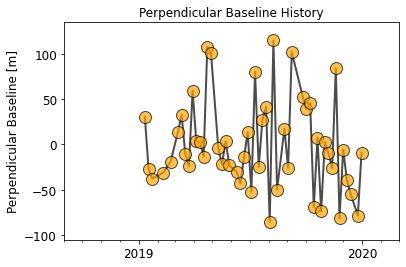

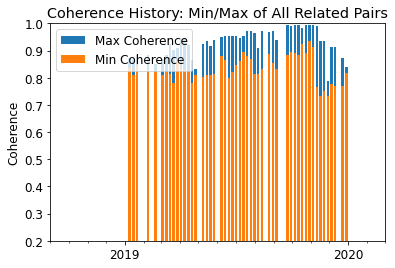

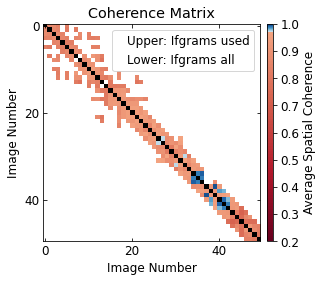

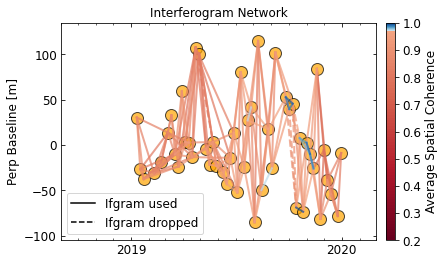

In [55]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep modify_network'
process = subprocess.run(command, shell=True)

plot_network.main(['inputs/ifgramStack.h5'])

<a id='generate_mask'></a>
## 2.4. Generate Quality Control Mask


Mask files can be can be used to mask pixels in the time-series processing. Below we generate an initial mask file `maskConnComp.h5` based on the connected components for all the interferograms, which is a metric for unwrapping quality. After time-series analysis is complete, we will calculate a mask from the temporal coherence or variation of phase or displacement with time to make `maskTempCoh.h5`.

input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 already exists.
2) output file is newer than input dataset: connectComponent.
run or skip: skip.
run view.py in MintPy version v1.3.2, date 2021-11-21
input file is mask file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/maskConnComp.h5 in bool format
file size in y/x: (3001, 3361)
input dataset: "['mask']"
num of datasets in file maskConnComp.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']


maskConnComp.h5


data   coverage in y/x: (0, 0, 3361, 3001)
subset coverage in y/x: (0, 0, 3361, 3001)
data   coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
subset coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
------------------------------------------------------------------------
colormap: jet
figure title: maskConnComp
figure size : [8.40, 6.00]
reading data ...
data has uniform and limited number (2 <= 20) of unique values --> discretize colormap
data    range: [False, True] 1
display range: [-0.5, 1.5] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
showing ...


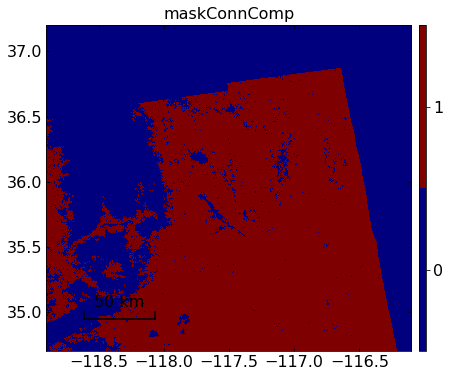

In [56]:
command='generate_mask.py inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update'
process = subprocess.run(command, shell=True)
view.main(['maskConnComp.h5', 'mask'])
msk_file = os.path.join(mintpy_dir, 'maskTempCoh.h5')

<a id='common_latlon'></a>
## 2.5. Reference Interferograms To Common Lat/Lon


In [57]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep reference_point'
process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, shell=True)
os.system('info.py inputs/ifgramStack.h5 | egrep "REF_"');

  REF_LAT                                         35.3241674175
  REF_LON                                         -116.6150009145
  REF_X                                           2743
  REF_Y                                           2252


<a id='invert_SBAS'></a>
## 2.6. Invert for SBAS Line-of-Sight Timeseries


In [58]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep invert_network'
process = subprocess.run(command, shell=True)

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-04-22 01:33:38.974097--
Current directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest
Go to work directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
read custom template file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/Ridgecrest.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/ATBD/methods/coseismic/wor

<a id='opt_correction'></a>
# 3. Optional Corrections

Phase distortions related to solid earth and ocean tidal effects as well as those due to temporal variations in the vertical stratification of the atmosphere can be mitigated using the approaches described below. At this point, it is expected that these corrections will not be needed to validate the mission requirements, but they may be used to produce the highest quality data products. Typically, these are applied to the estimated time series product rather than to the individual interferograms, since they are a function of the time of each radar acquisition.

<a id='solid_earth'></a>
## 3.1. Solid Earth Tide Correction

[MintPy provides functionality for this correction.]

<a id='tropo_corr'></a>
## 3.1. Tropospheric Delay Correction

Optional atmospheric correction utilizes the PyAPS (Jolivet et al., 2011, Jolivet and Agram, 2012) module within GIAnT (or eventually a merged replacement for GIAnT and MintPy). PyAPS is well documented, maintained and can be freely downloaded. PyAPS is included in GIAnT distribution). PyAPS currently includes support for ECMWF’s ERA-Interim, NOAA’s NARR and NASA’s MERRA weather models. A final selection of atmospheric models to be used for operational NISAR processing will be done during Phase C.

[T]ropospheric delay maps are produced from atmospheric data provided by Global Atmospheric Models. This method aims to correct differential atmospheric delay correlated with the topography in interferometric phase measurements. Global Atmospheric Models (hereafter GAMs)... provide estimates of the air temperature, the atmospheric pressure and the humidity as a function of elevation on a coarse resolution latitude/longitude grid. In PyAPS, we use this 3D distribution of atmospheric variables to determine the atmospheric phase delay on each pixel of each interferogram.

The absolute atmospheric delay is computed at each SAR acquisition date. For a pixel a_i at an elevation z at acquisition date i, the four surrounding grid points are selected and the delays for their respective elevations are computed. The resulting delay at the pixel a_i is then the bilinear interpolation between the delays at the four grid points. Finally, we combine the absolute delay maps of the InSAR partner images to produce the differential delay maps used to correct the interferograms.

[MintPy provides functionality for this correction.]

In [59]:
do_tropo_correction = False
########################################################################
'''
REFERENCE : https://github.com/insarlab/pyaps#2-account-setup-for-era5
Read Section 2 for ERA5 [link above] to create an account on the CDS website.
'''

if do_tropo_correction:
    if not Use_Staged_Data and not os.path.exists(Path.home()/'.cdsapirc'):
        print('NEEDED to download ERA5, link: https://cds.climate.copernicus.eu/user/register')
        UID = input('Please type your CDS_UID:')
        CDS_API = input('Please type your CDS_API:')
        
        cds_tmp = '''url: https://cds.climate.copernicus.eu/api/v2
        key: {UID}:{CDS_API}'''.format(UID=UID, CDS_API=CDS_API)
        os.system('echo "{cds_tmp}" > ~/.cdsapirc; chmod 600 ~/.cdsapirc'.format(cds_tmp = str(cds_tmp)))
    
    command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_troposphere'
    process = subprocess.run(command, shell=True)
    
    view.main(['inputs/ERA5.h5'])
    timeseries_filename = 'timeseries_ERA5.h5'
else:
    timeseries_filename = 'timeseries.h5'

<a id='phase_deramp'></a>
## 3.2. Phase Deramping


In [60]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep deramp'
process = subprocess.run(command, shell=True)

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-04-22 01:34:22.080445--
Current directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest
Go to work directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
read custom template file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/Ridgecrest.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/smallbaselineApp.cfg


********

<a id='topo_corr'></a>
## 3.3. Topographic Residual Correction

[MintPy provides functionality for this correction.]

In [61]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_topography'
process = subprocess.run(command, shell=True)

MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-04-22 01:34:30.458157--
Current directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest
Go to work directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
read custom template file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/Ridgecrest.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/smallbaselineApp.cfg


******************

<a id='decomp_ts'></a>
# 4. Decomposition of InSAR and GNSS time series into basis functions


<a id='insar_vel1'></a>
## 4.1. Estimate InSAR LOS Velocities

Given a time series of InSAR LOS displacements, the observations for a given pixel, $U(t)$, can be parameterized as:

$$U(t) = a \;+\; vt \;+\; c_1 cos (\omega_1t - \phi_{1,}) \;+\; c_2 cos (\omega_2t - \phi_2) \;+\; \sum_{j=1}^{N_{eq}} \left( h_j+f_j F_j (t-t_j) \right)H(t - t_j) \;+\; \frac{B_\perp (t)}{R sin \theta}\delta z \;+\; residual$$ 

which includes a constant offset $(a)$, velocity $(v)$, and amplitudes $(c_j)$ and phases $(\phi_j)$ of annual $(\omega_1)$ and semiannual $(\omega_2)$ sinusoidal terms.  Where needed we can include additional complexity, such as coseismic and postseismic processes parameterized by Heaviside (step) functions $H$ and postseismic functions $F$ (the latter typically exponential and/or logarithmic).   $B_\perp(t)$, $R$, $\theta$, and $\delta z$ are, respectively, the perpendicular component of the interferometric baseline relative to the first date, slant range distance, incidence angle and topography error correction for the given pixel. 

Thus, given either an ensemble of interferograms or the output of SBAS (displacement vs. time), we can write the LSQ problem as 

$$ \textbf{G}\textbf{m} = \textbf{d}$$

where $\textbf{G}$ is the design matrix (constructed out of the different functional terms in Equation 2 evaluated either at the SAR image dates for SBAS output, or between the dates spanned by each pair for interferograms), $\textbf{m}$ is the vector of model parameters (the coefficients in Equation 2) and $\textbf{d}$ is the vector of observations.  For GPS time series, $\textbf{G}, \textbf{d}, \textbf{m}$ are constructed using values evaluated at single epochs corresponding to the GPS solution times, as for SBAS InSAR input. 

With this formulation, we can obtain InSAR velocity estimates and their formal uncertainties (including in areas where the expected answer is zero). 

The default InSAR velocity fit in MintPy is to estimate a mean linear velocity $(v)$ in in the equation, which we do below. 

In [66]:
print(mintpy_dir)
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep velocity'
process = subprocess.run(command, shell=True)
vel_file = os.path.join(mintpy_dir, 'velocity.h5')
vel = readfile.read(vel_file, datasetName = 'velocity')[0] * 100.  #read and convert velocities from m to cm

# optionally set masked pixels to NaN
#msk = readfile.read(msk_file)[0]
#vel[msk == 0] = np.nan

/home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
MintPy version v1.3.2, date 2021-11-21
--RUN-at-2022-04-22 01:36:41.027195--
Current directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest
Go to work directory: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy
read custom template file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/Ridgecrest.cfg
update default template based on input custom template
    mintpy.load.incAngleFile: ../incidenceAngle/\*.vrt --> ../incidenceAngle/*.vrt
    mintpy.load.azAngleFile: ../azimuthAngle/\*.vrt --> ../azimuthAngle/*.vrt
    mintpy.troposphericDelay.method: pyaps --> no
copy Ridgecrest.cfg to inputs   directory for backup.
c

Now we plot the mean linear velocity fit. The MintPy `view` module automatically reads the temporal coherence mask `maskTempCoh.h5` and applies that to mask out pixels with unreliable velocities (white).

run view.py in MintPy version v1.3.2, date 2021-11-21
input file is velocity file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/velocity.h5 in float32 format
file size in y/x: (3001, 3361)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 4
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 3361, 3001)
subset coverage in y/x: (0, 0, 3361, 3001)
data   coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
subset coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
------------------------------------------------------------------------
colormap: RdBu
figure title: LOS_Velocity
figure size : [8.40, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
set reference pixel to: [200, 950]
data    range: [-11.828031, 9.240326] cm/year
display range: [-25.0, 25.0] cm/year
display data in 

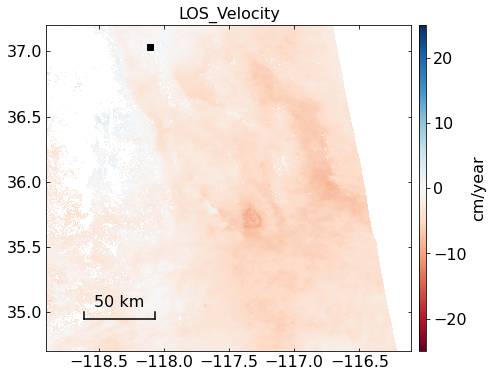

In [67]:
scp_args = 'velocity.h5 velocity -v -25 25 --ref-yx 200 950 --colormap RdBu --figtitle LOS_Velocity' # --plot-setting ' + plot_config_file
view.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

<a id='co_step1'></a>
## 4.2. Estimate InSAR Coseismic Displacement

We can use the same time series to estimate the coseismic displacement as a Heaviside $H$ or step function at the time of an earthquake or a number $N_{eq}$ of earthquakes. In the above equation this is the $$\sum_{j=1}^{N_{eq}} \left( h_j+f_j F_j (t-t_j) \right)H(t - t_j) \;$$ set of terms. For simplicity, we consider only one earthquake and we assume the postseismic displacement functions $F$ are small compared to the coseismic displacements, so we only need to solve for the coefficient $h$ of each interferogram pixel.

We call the MintPy `timeseries2velocity.py` program again and specify the time of the earthquake $t_j$. The fit will also include the linear velocity rate separated from the step function amplitude. Both estimated coefficients have their associated uncertainties.

In [70]:
command = 'timeseries2velocity.py ' + timeseries_filename + ' --step ' + sites[site]['earthquakeDate']
process = subprocess.run(command, shell=True)

EQdataset = 'step' + sites[site]['earthquakeDate']
EQstep = readfile.read(vel_file, datasetName = EQdataset)[0] * 100.  #read and convert coseismic step from m to cm

open timeseries file: timeseries.h5
--------------------------------------------------
dates from input file: 50
['20190111', '20190117', '20190123', '20190210', '20190222', '20190306', '20190312', '20190318', '20190324', '20190330', '20190405', '20190411', '20190417', '20190423', '20190429', '20190511', '20190517', '20190523', '20190529', '20190610', '20190616', '20190622', '20190628', '20190704', '20190710', '20190716', '20190722', '20190728', '20190803', '20190809', '20190815', '20190827', '20190902', '20190908', '20190926', '20191002', '20191008', '20191014', '20191020', '20191026', '20191101', '20191107', '20191113', '20191119', '20191125', '20191201', '20191207', '20191213', '20191225', '20191231']
--------------------------------------------------
using all dates to calculate the velocity
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : ['20190705']
   

velocity.h5


Now we can view the step function amplitude and the new linear velocity estimate.

run view.py in MintPy version v1.3.2, date 2021-11-21
input file is velocity file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/velocity.h5 in float32 format
file size in y/x: (3001, 3361)
input dataset: "['step20190705']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 4
datasets to exclude (0):
[]
datasets to display (1):
['step20190705']
data   coverage in y/x: (0, 0, 3361, 3001)
subset coverage in y/x: (0, 0, 3361, 3001)
data   coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
subset coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
------------------------------------------------------------------------
colormap: RdBu
figure title: LOS_Coseismic
figure size : [8.40, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
set reference pixel to: [200, 950]
data    range: [-48.350998, 83.89262] cm
display range: [-40.0, 40.0] cm
display data in t

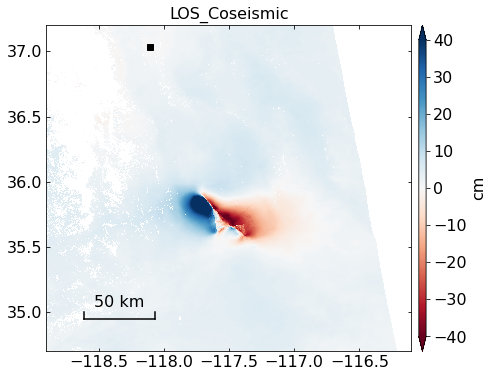

run view.py in MintPy version v1.3.2, date 2021-11-21
input file is velocity file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/velocity.h5 in float32 format
file size in y/x: (3001, 3361)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 4
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 3361, 3001)
subset coverage in y/x: (0, 0, 3361, 3001)
data   coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
subset coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
------------------------------------------------------------------------
colormap: RdBu
figure title: LOS_Velocity
figure size : [8.40, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
set reference pixel to: [200, 950]
data    range: [-11.828031, 9.240326] cm/year
display range: [-25.0, 25.0] cm/year
display data in 

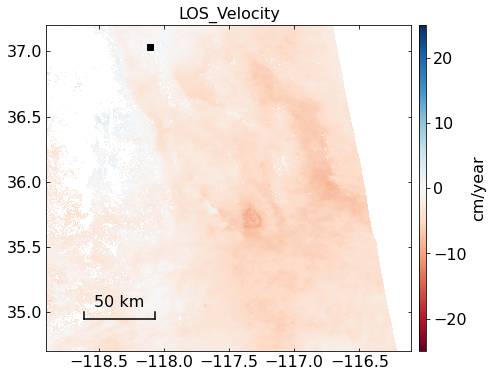

In [69]:
scp_args = 'velocity.h5 step' + sites[site]['earthquakeDate'] + ' -v -40 40 --ref-yx 200 950 --colormap RdBu --figtitle LOS_Coseismic' # --plot-setting ' + plot_config_file
view.main(scp_args.split())
scp_args = 'velocity.h5 velocity -v -25 25 --ref-yx 200 950 --colormap RdBu --figtitle LOS_Velocity' # --plot-setting ' + plot_config_file
view.main(scp_args.split())

<a id='co_gps'></a>
## 4.3. Find Collocated GNSS Stations

The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

In [71]:
# get analysis metadata from InSAR velocity file
atr = readfile.read_attribute(vel_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
lat_step = float(atr['Y_STEP'])
lon_step = float(atr['X_STEP'])
N = float(atr['Y_FIRST'])
W = float(atr['X_FIRST'])
S = N + lat_step * length
E = W + lon_step * width
start_date = atr.get('START_DATE', None)
end_date = atr.get('END_DATE', None)
start_date_gnss = dt.strptime(start_date, "%Y%m%d")
end_date_gnss = dt.strptime(end_date, "%Y%m%d")
inc_angle = int(float(atr.get('incidenceAngle', None)))
az_angle = int(float(atr.get('azimuthAngle', None))) 

#Set GNSS Parameters
gps_completeness_threshold = 0.9     #0.9  #percent of data timespan with valid GNSS epochs
gps_residual_stdev_threshold = 20.   #0.03  #0.03  #max threshold standard deviation of residuals to linear GNSS fit

# search for collocated GNSS stations
site_names, site_lats, site_lons = gps.search_gps(SNWE=(S,N,W,E), 
                                                  start_date=start_date_gnss.strftime('%Y%m%d'),
                                                  end_date=end_date_gnss.strftime('%Y%m%d'))
site_names = [str(stn) for stn in site_names]
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

Initial list of 111 stations used in analysis:
['ALPP', 'ASHM', 'BEAT', 'BEER', 'BEPK', 'BFSH', 'BSRY', 'CABS', 'CAC2', 'CAIS', 'CAL8', 'CCCC', 'CDMT', 'CERR', 'COSJ', 'COSO', 'CPBN', 'CRAM', 'DEVL', 'DS13', 'DTPG', 'EAGL', 'EDPP', 'ELTN', 'FOXG', 'FZHS', 'GOL2', 'GOLD', 'HAR7', 'HCMN', 'HIGH', 'HIVI', 'HW95', 'INDE', 'ISLK', 'KENN', 'LAVA', 'LJRN', 'LNMT', 'LONP', 'NEVA', 'NVAG', 'OASI', 'OLNC', 'OWEN', 'P091', 'P092', 'P093', 'P094', 'P311', 'P462', 'P463', 'P464', 'P465', 'P466', 'P467', 'P468', 'P553', 'P554', 'P556', 'P557', 'P558', 'P560', 'P567', 'P568', 'P569', 'P570', 'P571', 'P573', 'P579', 'P580', 'P583', 'P588', 'P590', 'P591', 'P592', 'P593', 'P594', 'P595', 'P596', 'P597', 'P604', 'P615', 'P616', 'P617', 'P618', 'P619', 'P620', 'P808', 'P811', 'P812', 'PANA', 'PEAR', 'PHIN', 'PHLB', 'RAMT', 'REP3', 'REPO', 'RSTP', 'RYAN', 'SHOS', 'TEHA', 'THCP', 'TIVA', 'TLCC', 'TOWG', 'TPOG', 'WASG', 'WHFG', 'WLHG', 'WORG']


<a id='gps_ts'></a>
## 4.4. Get GNSS Position Time Series


In [72]:
# get daily position solutions for GNSS stations
use_stn = []  #stations to keep
bad_stn = []  #stations to toss
use_lats = [] 
use_lons = []
counter = 0

for stn in site_names:
    gps_obj = gps.GPS(site = stn, data_dir = os.path.join(mintpy_dir,'GPS'))
    gps_obj.open(print_msg='False')
    
    # count number of dates in time range
    dates = gps_obj.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss,end_date_gnss])
    gnss_count = int(gnss_count[0])
    
    # for this quick screening check of data quality, we use the constant incidence and azimuth angles 
    # get standard deviation of residuals to linear fit
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, az_angle)
    #disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, head_angle, az_angle)
    disp_detrended = signal.detrend(disp_los)
    stn_stdv = np.std(disp_detrended)
   
    # select GNSS stations based on data completeness and scatter of residuals
    disp_detrended = signal.detrend(disp_los)
    if range_days*gps_completeness_threshold <= gnss_count:
        if stn_stdv > gps_residual_stdev_threshold:
            bad_stn.append(stn)
        else:
            use_stn.append(stn)
            use_lats.append(site_lats[counter])
            use_lons.append(site_lons[counter])
    else:
        bad_stn.append(stn)
    counter+=1

site_names = use_stn
site_lats = use_lats
site_lons = use_lons

# [optional] manually remove additional stations
gnns_to_remove=['CAL8', 'P094', 'COSO', 'CAC2']

for i, gnss_site in enumerate(gnns_to_remove):
    if gnss_site in site_names:
        site_names.remove(gnss_site)
    if gnss_site not in bad_stn:
        bad_stn.append(gnss_site)
    
print("Final list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)

None
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical dire

<a id='gps_los'></a>
## 4.5. Make GNSS LOS Velocities

As a first approximation to estimate coseismic displacements, we take one day before and one (or three) day after earthquake.

In [74]:
EQdate_int = int(sites[site]['earthquakeDate'])
EQpre_date = str(EQdate_int - 1)  # should convert to real date object first
EQpost_date = str(EQdate_int + 3)

gps_comp = 'enu2los'
meta = readfile.read_attribute('velocity.h5')
SNWE = ut.four_corners(meta)
#vel = gps.get_gps_los_obs(meta, 'velocity',     site_names, start_date='20150101', end_date='20190619')
displ = gps.get_gps_los_obs(meta, 
                            'displacement', 
                            site_names, 
                            start_date=EQpre_date, 
                            end_date=EQpost_date,
                            gps_comp=gps_comp, 
                            redo=True) * 100.
print('\n site   vel-los [cm/yr]')
print(np.array([site_names,displ]).T)

default GPS observation file name: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/gps_enu2los.csv
calculating GPS observation ...
use incidence / azimuth angle from file: geometryGeo.h5
[==================================================] 71/71 WORG   29s /     0s 
write GPS observations to file: /home/jovyan/ATBD/methods/coseismic/work/coseismic_ouputs/RidgecrestA64/MintPy/gps_enu2los.csv

 site   vel-los [cm/yr]
[['BEPK' '4.929945']
 ['BSRY' '0.37338734']
 ['CABS' '0.54339767']
 ['CAIS' '0.5887091']
 ['CCCC' '3.5291493']
 ['CDMT' '0.015223026']
 ['CPBN' '0.280416']
 ['DS13' '-1.3486832']
 ['DTPG' '0.15788078']
 ['EDPP' '0.16288757']
 ['FZHS' '0.40108562']
 ['GOL2' '-2.4391623']
 ['HAR7' '0.3268987']
 ['HCMN' '-0.04887581']
 ['HIVI' '0.10552406']
 ['ISLK' '0.6982416']
 ['LJRN' '0.96690655']
 ['LNMT' '-0.64727664']
 ['NEVA' '0.2876386']
 ['NVAG' '0.19738078']
 ['P091' '0.6239414']
 ['P092' '0.69249123']
 ['P093' '0.44144392']
 ['P311' '0.092339516']
 ['P

calculating station lat/lon
reading time and displacement in east/north/vertical direction
fit parameters (constant, linear velocity, step) [0.10636971 0.00127248 0.1153931 ]


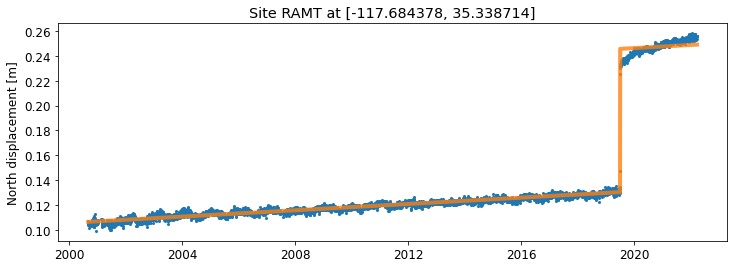

In [75]:
# 1. download & read GNSS displacement time series
site_id = 'RAMT'
gps_obj = gps.GPS(site=site_id, data_dir = os.path.join(mintpy_dir,'GPS'))
gps_obj.open()

# 2. fit time function
model = {
    'polynomial' : 1,
    'step'       : [sites[site]['earthquakeDate']]
}
G, m, e2 = time_func.estimate_time_func(model, gps_obj.date_list, gps_obj.dis_n)

print('fit parameters (constant, linear velocity, step)',m)

# 3. reconstruct time series from estimated time function parameters
date_list_fit = ptime.get_date_range(gps_obj.date_list[0], gps_obj.date_list[-1])
dates_fit = ptime.date_list2vector(date_list_fit)[0]
G_fit = time_func.get_design_matrix4time_func(date_list_fit, model)
dis_ts_fit = np.matmul(G_fit, m)

# plot
fig, ax = plt.subplots(figsize=[12, 4])
ax.plot(gps_obj.dates, gps_obj.dis_n, '.', ms=4)
ax.plot(dates_fit, dis_ts_fit, lw=4, alpha=0.8)
ax.set_ylabel('North displacement [m]')
ax.set_title(f'Site {site_id} at [{gps_obj.site_lon:.6f}, {gps_obj.site_lat:.6f}]')
plt.show()

calculating station lat/lon
reading time and displacement in east/north/vertical direction
fit parameters (constant, linear velocity, step) [-0.05169331  0.01141413 -0.01639276]


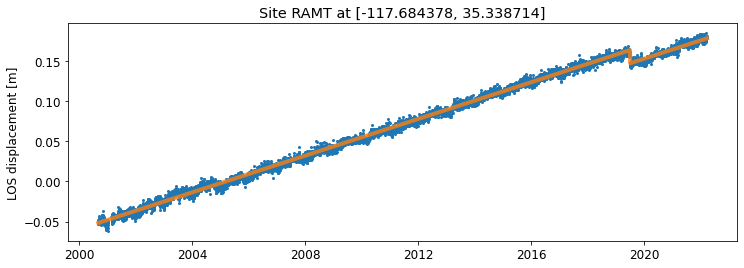

In [76]:
# get InSAR geometry file
geom_file = ut.get_geometry_file(['incidenceAngle','azimuthAngle'], work_dir=mintpy_dir, coord='geo')

# 1. download & read GNSS displacement time series
site_id = 'RAMT'
gps_obj = gps.GPS(site=site_id, data_dir = os.path.join(mintpy_dir,'GPS'))
gps_obj.open()

# 2. fit time function
model = {
    'polynomial' : 1,
    'step'       : [sites[site]['earthquakeDate']]
}
# project the GNSS three components to InSAR LOS
#dis_los = ut.enu2los(gps_obj.dis_e,gps_obj.dis_n,gps_obj.dis_u,inc_angle,az_angle)

# fit whole time series for this station
# date range for this station
statStart = gps_obj.date_list[0]
statEnd = gps_obj.date_list[-1]

dates, dis_los, std, site_lalo, ref_site_lalo = gps_obj.read_gps_los_displacement(geom_file, 
                                                                                  start_date=statStart, 
                                                                                  end_date=statEnd, 
                                                                                  ref_site=None,
                                                                                  gps_comp=gps_comp, 
                                                                                  print_msg=False)

G, m, e2 = time_func.estimate_time_func(model, gps_obj.date_list, dis_los)

print('fit parameters (constant, linear velocity, step)',m)

# 3. reconstruct time series from estimated time function parameters
date_list_fit = ptime.get_date_range(statStart, statEnd)
dates_fit = ptime.date_list2vector(date_list_fit)[0]
G_fit = time_func.get_design_matrix4time_func(date_list_fit, model)
dis_ts_fit = np.matmul(G_fit, m)

# plot
fig, ax = plt.subplots(figsize=[12, 4])
ax.plot(gps_obj.dates, dis_los, '.', ms=4)
ax.plot(dates_fit, dis_ts_fit, lw=4, alpha=0.8)
ax.set_ylabel('LOS displacement [m]')
ax.set_title(f'Site {site_id} at [{gps_obj.site_lon:.6f}, {gps_obj.site_lat:.6f}]')
plt.show()

Now do the LOS fits for all good GPS stations

In [77]:
gnss_los_coseis_cm = []
plotGNSSfit = False

# need to update these to keep consistent
site_lats = []
site_lons = []

twoQuake = False
# fit time function
if twoQuake:
    modelParam = {
        'polynomial' : 1,
        'step'       : [sites[site]['earthquakeDate'], sites[site]['earthquakeDate2']],
    }
else:
    modelParam = {
        'polynomial' : 1,
        'step'       : [sites[site]['earthquakeDate']],
    }

for stn in site_names:
    gps_obj = gps.GPS(site = stn, data_dir = os.path.join(mintpy_dir,'GPS'))
    gps_obj.open()
    
    site_lats.append(gps_obj.site_lat) # save site location in list
    site_lons.append(gps_obj.site_lon)
    
    # fit whole time series for this station
    # date range for this station
    statStart = gps_obj.date_list[0]
    statEnd = gps_obj.date_list[-1]

    dates, dis_los, std, site_lalo, ref_site_lalo = gps_obj.read_gps_los_displacement(geom_file, 
                                                                                      start_date=statStart, 
                                                                                      end_date=statEnd, 
                                                                                      ref_site=None,
                                                                                      gps_comp=gps_comp, 
                                                                                      print_msg=False)

    
    G, m, e2 = time_func.estimate_time_func(model, gps_obj.date_list, dis_los)

    print('station',stn,'fit parameters (constant, linear velocity, step)',m)
    gnss_los_coseis_cm.append(m[2]*100.)  # save step function and convert to cm for convenience
    
    if (plotGNSSfit):
        # 3. reconstruct time series from estimated time function parameters
        date_list_fit = ptime.get_date_range(gps_obj.date_list[0], gps_obj.date_list[-1])
        dates_fit = ptime.date_list2vector(date_list_fit)[0]
        G_fit = time_func.get_design_matrix4time_func(date_list_fit, model)
        dis_ts_fit = np.matmul(G_fit, m)
        
        dates = gps_obj.date_list
        index_start = dates.index(gps_obj.date_list[0])
        index_end = dates.index(gps_obj.date_list[-1])
        print ('index_start',index_start,'end',index_end)
        print('len dates',len(dates),'dis_los',len(dis_los),'dates_fit',len(dates_fit))
        cut_dates = dates[index_start:index_end]
        cut_dates_vec = ptime.date_list2vector(cut_dates)[0]
        cut_dis_los = dis_los[index_start:index_end]

        # plot
        fig, ax = plt.subplots(figsize=[12, 4])
        ax.plot(cut_dates_vec, cut_dis_los, '.', ms=4)
        ax.plot(dates_fit, dis_ts_fit, lw=4, alpha=0.8)
        ax.set_ylabel('LOS displacement [m]')
        ax.set_title(f'Site {stn} at [{gps_obj.site_lon:.6f}, {gps_obj.site_lat:.6f}]')
        plt.show()
        
    
print(gnss_los_coseis_cm)

# compare the simple difference displacements to the time-series step fits
dispDiff = displ - gnss_los_coseis_cm
print('difference in displacement estimate (cm)\n', dispDiff)
print('difference in coseismic displacement estimate (%)\n',(displ + gnss_los_coseis_cm) / 2)

calculating station lat/lon
reading time and displacement in east/north/vertical direction
station BEPK fit parameters (constant, linear velocity, step) [-0.39555916  0.01301698  0.05690203]
calculating station lat/lon
reading time and displacement in east/north/vertical direction
station BSRY fit parameters (constant, linear velocity, step) [ 0.76405567  0.0133568  -0.00603678]
calculating station lat/lon
reading time and displacement in east/north/vertical direction
station CABS fit parameters (constant, linear velocity, step) [-0.4043308   0.01339657 -0.00238126]
calculating station lat/lon
reading time and displacement in east/north/vertical direction
station CAIS fit parameters (constant, linear velocity, step) [0.07299042 0.01386861 0.01236194]
calculating station lat/lon
reading time and displacement in east/north/vertical direction
station CCCC fit parameters (constant, linear velocity, step) [0.29369155 0.01252556 0.04338854]
calculating station lat/lon
reading time and displa

<a id='gps_insar'></a>
## 4.6. Re-Reference GNSS and InSAR LOS Coseismic step


In [78]:
# reference GNSS stations to GNSS reference site
ref_site_ind = site_names.index(sites[site]['gps_ref_site_name'])
displRelRef = displ - displ[ref_site_ind]

# reference InSAR to GNSS reference site
ref_site_lat = float(site_lats[ref_site_ind])
ref_site_lon = float(site_lons[ref_site_ind])
ref_y, ref_x = ut.coordinate(atr).geo2radar(ref_site_lat, ref_site_lon)[:2]
print ('new reference pixel for InSAR y,x:',ref_y, ref_x,'at lat, lon',ref_site_lat,ref_site_lon)
EQstep = EQstep - EQstep[ref_y, ref_x]

new reference pixel for InSAR y,x: 1846 510 at lat, lon 35.66226995995774 -118.47591732475081


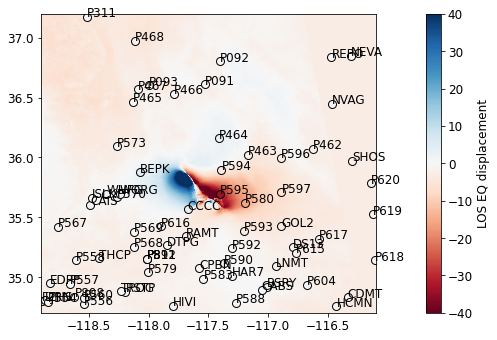

In [79]:
# plot GNSS stations on InSAR coseismic field
vmin, vmax = -40, 40
cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.imshow(EQstep, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest', extent=(W, E, S, N))
cbar1 = fig.colorbar(img1, ax=ax)
cbar1.set_label('LOS EQ displacement')

for lat, lon, obs in zip(site_lats, site_lons, displRelRef):
    color = cmap((obs - vmin)/(vmax - vmin))
    ax.scatter(lon, lat, color=color, s=8**2, edgecolors='k')
for i, label in enumerate(site_names):
     plt.annotate(label, (site_lons[i], site_lats[i]), color='black')

out_fig = os.path.abspath('coseismic_insar_vs_gnss.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

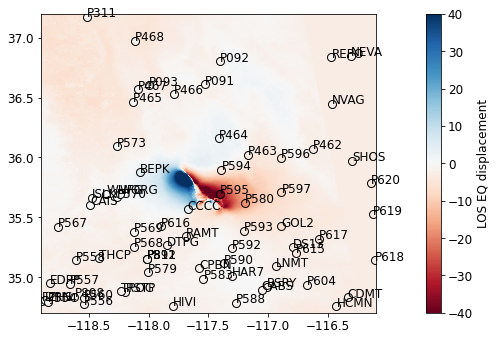

In [80]:
# same re-reference for the time-series GNSS fit
ref_site_ind = site_names.index(sites[site]['gps_ref_site_name'])
displFitRelRef = gnss_los_coseis_cm - gnss_los_coseis_cm[ref_site_ind]

# plot GNSS stations on InSAR coseismic field
vmin, vmax = -40, 40
cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.imshow(EQstep, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest', extent=(W, E, S, N))
cbar1 = fig.colorbar(img1, ax=ax)
cbar1.set_label('LOS EQ displacement')

for lat, lon, obs in zip(site_lats, site_lons, displFitRelRef):
    color = cmap((obs - vmin)/(vmax - vmin))
    ax.scatter(lon, lat, color=color, s=8**2, edgecolors='k')
for i, label in enumerate(site_names):
     plt.annotate(label, (site_lons[i], site_lats[i]), color='black')

out_fig = os.path.abspath('coseismic_insar_vs_gnss_fit.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

<a id='nisar_validation'></a>
# 5. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison 


<a id='make_vel'></a>
## 5.1. Make Displacement Residuals at GNSS Locations


In [83]:
#Set Parameters
pixel_radius = 5   #number of InSAR pixels to average for comparison with GNSS

#Create dictionary with the stations as the key and all their info as an array 
stn_dict = {}  

#Loop over GNSS station locations
for i in range(0,len(site_names)): 
    
    # convert GNSS station lat/lon information to InSAR x/y grid
    stn_lat = site_lats[i]
    stn_lon = site_lons[i]
    x_value = round((stn_lon - W)/lon_step)
    y_value = round((stn_lat - N)/lat_step)
    
    # get velocities and residuals
    disp_GPS = displ[i]
    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    disp_px_rad = EQstep[y_value-pixel_radius:y_value+1+pixel_radius, 
                     x_value-pixel_radius:x_value+1+pixel_radius]
    disp_InSAR = np.median(disp_px_rad)
    residual = disp_GPS - disp_InSAR

    # populate data structure
    values = [x_value, y_value, disp_InSAR, disp_GPS, residual, stn_lat, stn_lon]
    stn = site_names[i]
    stn_dict[stn] = values
    
# extract data from structure
res_list = []
insar_disp = []
gnss_disp = []
lat_list = []
lon_list = []
for i in range(len(site_names)): 
    stn = site_names[i]
    insar_disp.append(stn_dict[stn][2])
    gnss_disp.append(stn_dict[stn][3])
    res_list.append(stn_dict[stn][4])
    lat_list.append(stn_dict[stn][5])
    lon_list.append(stn_dict[stn][6])
num_stn = len(site_names) 

<a id='make_velres1'></a>
## 5.2. Make Double-differenced Velocity Residuals


In [84]:
diff_res_list = []
stn_dist_list = []
dict_keys = list(stn_dict.keys())

# remove reference stn
site_names_analysis = list(site_names)
#site_names_analysis.remove(gps_ref_site_name)

# loop over stations
for i in range(len(site_names_analysis)-1):
    stn1 = dict_keys[i]
    for l in range(i + 1, len(dict_keys)):
        stn2 = dict_keys[l]
        # calculate between-station velocity residual
        # stn_dict values = [x_value, y_value, vel_InSAR, vel_GPS, residual, stn_lat, stn_lon]
        # index 3 = gps vel
        gps_vel_diff = stn_dict[stn1][3] - stn_dict[stn2][3]
        # index 2 = insar vel 
        insar_vel_diff = stn_dict[stn1][2]-stn_dict[stn2][2]
        # calculate double-difference
        diff_res = gps_vel_diff - insar_vel_diff
        diff_res_list.append(diff_res)
        # get distance between selected station
        # index 5 is lat, 6 is lon
        dlat = (stn_dict[stn1][5]-stn_dict[stn2][5])
        dlon = (stn_dict[stn1][6]-stn_dict[stn2][6])*np.sin(stn_dict[stn1][5])
        #convert degrees to km
        stn_dist = math.sqrt(dlat**2 + dlon**2)*111
        stn_dist_list.append(stn_dist)

<a id='amp_vs_dist'></a>
## 5.3. Amplitude vs. Distance of Double Differences (not quite a structure function)

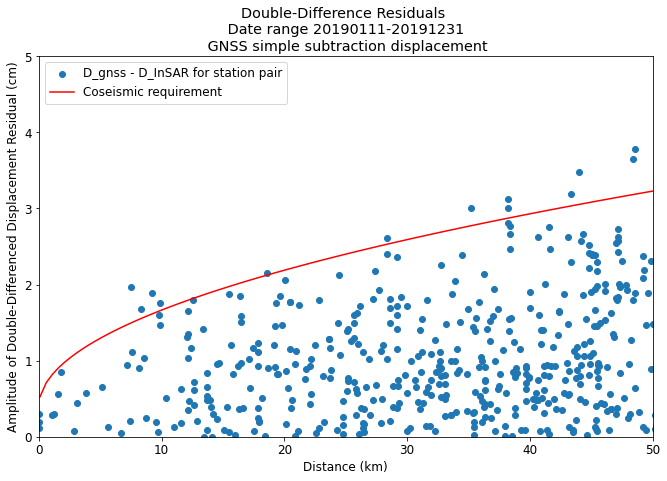

In [85]:
dist_th = np.linspace(0.1,50,100)  # distances for evaluation
acpt_error = 4*(1+np.sqrt(dist_th))  # coseismic threshold in mm
acpt_error_cm = acpt_error/10.
abs_ddiff_disp = [abs(i) for i in diff_res_list]

fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(stn_dist_list,abs_ddiff_disp,label='D_gnss - D_InSAR for station pair')
plt.plot(dist_th, acpt_error_cm, 'r',label='Coseismic requirement')
plt.ylim(0,5)
plt.xlim(0,50)
plt.legend(loc='upper left')
plt.title(f"Double-Difference Residuals \n Date range {start_date}-{end_date} \n GNSS simple subtraction displacement")
plt.xlabel("Distance (km)")
plt.ylabel("Amplitude of Double-Differenced Displacement Residual (cm)")
plt.show()

out_fig = os.path.abspath('coseismic_insar-gnss_vs_distance.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

<a id='nisar_anal'></a>
## 5.4. InSAR Residuals Analysis


In [86]:
# version of GNSS coseismic displacements from full time-series fit
#Create dictionary with the stations as the key and all their info as an array 
stn_fit_dict = {}  

#Loop over GNSS station locations
for i in range(0,len(site_names)): 
    
    # convert GNSS station lat/lon information to InSAR x/y grid
    # convert GNSS station lat/lon information to InSAR x/y grid
    stn_lat = site_lats[i]
    stn_lon = site_lons[i]
    x_value = round((stn_lon - W)/lon_step)
    y_value = round((stn_lat - N)/lat_step)
    
    # get velocities and residuals
    disp_GPS_fit = gnss_los_coseis_cm[i]
    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    disp_px_rad = EQstep[y_value-pixel_radius:y_value+1+pixel_radius, 
                     x_value-pixel_radius:x_value+1+pixel_radius]
    disp_InSAR = np.median(disp_px_rad)

    residual_fit = disp_GPS_fit - disp_InSAR

    # populate data structure
    values = [x_value, y_value, disp_InSAR, disp_GPS_fit, residual, stn_lat, stn_lon]
    stn = site_names[i]
    stn_fit_dict[stn] = values
    
# extract data from structure
res_list = []
insar_disp = []
gnss_disp = []
lat_list = []
lon_list = []
for stn in site_names: 
    insar_disp.append(stn_fit_dict[stn][2])
    gnss_disp.append(stn_fit_dict[stn][3])
    res_list.append(stn_fit_dict[stn][4])
    lat_list.append(stn_fit_dict[stn][5])
    lon_list.append(stn_fit_dict[stn][6])
num_stn = len(site_names) 

<a id='make_velres2'></a>
## 5.5. Make Double-differenced Velocity Residuals


In [87]:
stn_dict = stn_fit_dict # use the fit displacements for the rest of the calculations

diff_res_fit_list = []
stn_dist_list = []
dict_keys = list(stn_dict.keys())

# remove reference stn
site_names_analysis = list(site_names)
#site_names_analysis.remove(gps_ref_site_name)

# loop over stations
for i in range(len(site_names_analysis)-1):
    stn1 = dict_keys[i]
    for l in range(i + 1, len(dict_keys)):
        stn2 = dict_keys[l]
        # calculate between-station velocity residual
        # stn_dict values = [x_value, y_value, vel_InSAR, vel_GPS, residual, stn_lat, stn_lon]
        # index 3 = gps vel
        gps_vel_diff = stn_dict[stn1][3] - stn_dict[stn2][3]
        # index 2 = insar vel 
        insar_vel_diff = stn_dict[stn1][2]-stn_dict[stn2][2]
        # calculate double-difference
        diff_res = gps_vel_diff - insar_vel_diff
        diff_res_fit_list.append(diff_res)
        # get distance between selected station
        # index 5 is lat, 6 is lon
        dlat = (stn_dict[stn1][5]-stn_dict[stn2][5])
        dlon = (stn_dict[stn1][6]-stn_dict[stn2][6])*np.sin(stn_dict[stn1][5])
        #convert degrees to km
        stn_dist = math.sqrt(dlat**2 + dlon**2)*111
        stn_dist_list.append(stn_dist)

<a id='ampvsdist2'></a>
## 5.6. Amplitude vs. Distance of Double-differences (not quite a structure function)


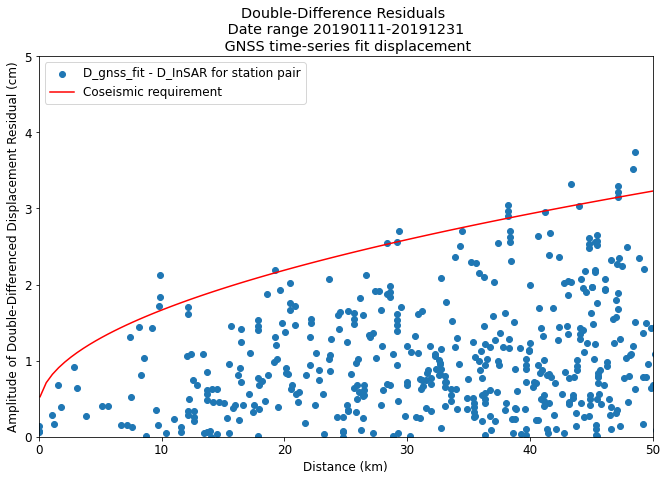

In [88]:
abs_ddiff_disp_fit = [abs(i) for i in diff_res_fit_list]

fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(stn_dist_list,abs_ddiff_disp_fit,label='D_gnss_fit - D_InSAR for station pair')
plt.plot(dist_th, acpt_error_cm, 'r',label='Coseismic requirement')
plt.ylim(0,5)
plt.xlim(0,50)
plt.legend(loc='upper left')
plt.title(f"Double-Difference Residuals \n Date range {start_date}-{end_date} \n GNSS time-series fit displacement")
plt.xlabel("Distance (km)")
plt.ylabel("Amplitude of Double-Differenced Displacement Residual (cm)")
plt.show()

out_fig = os.path.abspath('coseismic_insar-gnss_fit_vs_distance.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

<a id='nisar_validation2'></a>
# 6. NISAR Validation Approach 2: InSAR-only Structure Function

<a id='appendix'></a>
# 7. Appendix: Supplementary Comparisons and Plots


<a id='compare_raw'></a>
## 7.1. Compare Raw Velocities


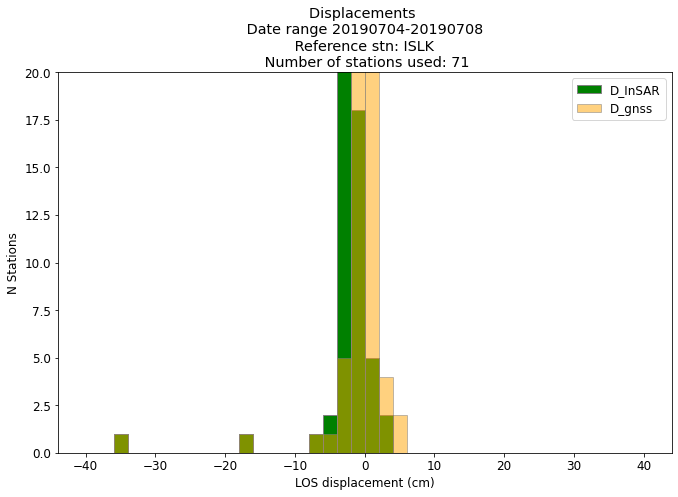

In [89]:
vmin, vmax = -40, 40
plt.figure(figsize=(11,7))
plt.hist(insar_disp, range = [vmin, vmax],bins = 40, color = "green",edgecolor='grey',label='D_InSAR')
plt.hist(gnss_disp, range = [vmin, vmax],bins = 40, color = "orange",edgecolor='grey',label='D_gnss', alpha=0.5)
plt.legend(loc='upper right')
plt.title(f"Displacements \n Date range {EQpre_date}-{EQpost_date} \n Reference stn: {sites[site]['gps_ref_site_name']} \n Number of stations used: {num_stn}")
plt.xlabel('LOS displacement (cm)')
plt.ylabel('N Stations')
plt.ylim(0,20)
plt.show()

<a id='plot_vel'></a>
## 7.2. Plot Velocity Residuals


In [ ]:
plt.figure(figsize=(11,7))
plt.hist(res_list,bins = 40, range = [vmin, vmax],edgecolor='grey',color="darkblue",linewidth=1,label='D_gnss - D_InSAR (area average)')
plt.legend(loc='upper right')
plt.title(f"Residuals \n Date range {start_date}-{end_date} \n Reference stn: {sites[site]['gps_ref_site_name']} \n Number of stations used: {num_stn}")
plt.xlabel('Displacement Residual (cm)')
plt.ylabel('N Stations')
plt.ylim(0,15)
plt.show()

<a id='plot_velres'></a>
## 7.3. Plot Double-differenced Residuals


In [ ]:
plt.figure(figsize=(11,7))
plt.hist(diff_res_list, range = [vmin, vmax],bins = 40, color = "darkblue",edgecolor='grey',label='D_gnss_(s1-s2) - D_InSAR_(s1-s2)')
plt.legend(loc='upper right')
plt.title(f"Difference Residuals \n Date range {start_date}-{end_date} \n Reference stn: {sites[site]['gps_ref_site_name']} \n Number of stations used: {num_stn}")
plt.xlabel('Double Differenced Displacement Residual (cm)')
plt.ylabel('N Stations')
plt.ylim(0,250)
plt.show()

<a id='appendix_gps'></a>
## 7.4. GPS Position Plots


calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction

/tmp/ipykernel_425/1723408770.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,5))


calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction

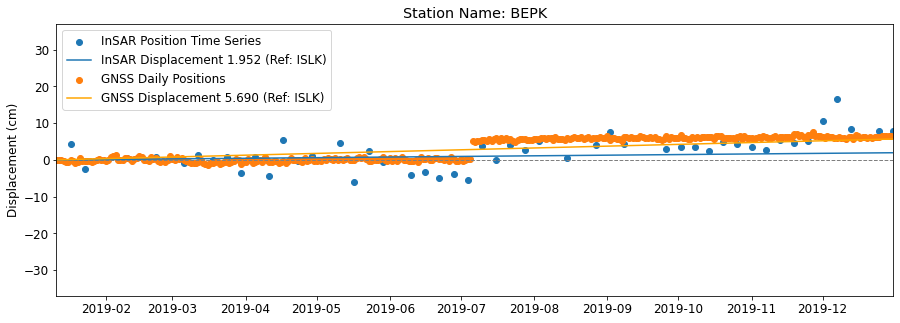

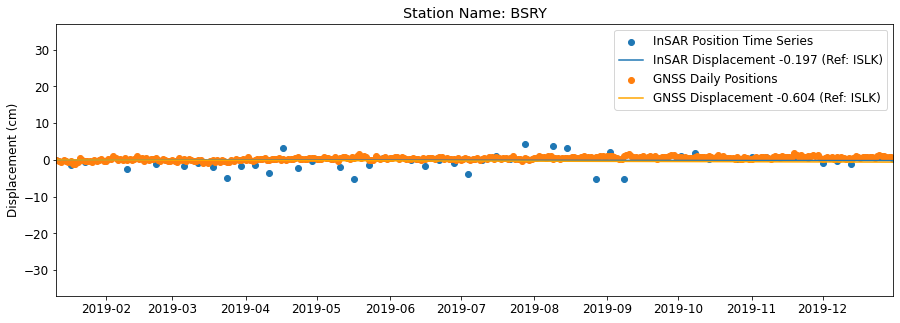

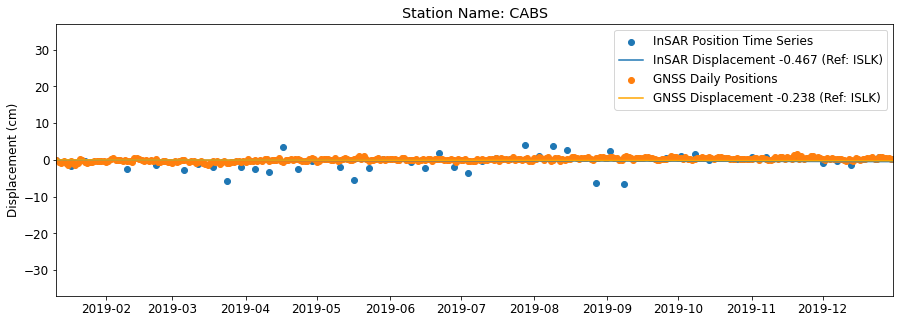

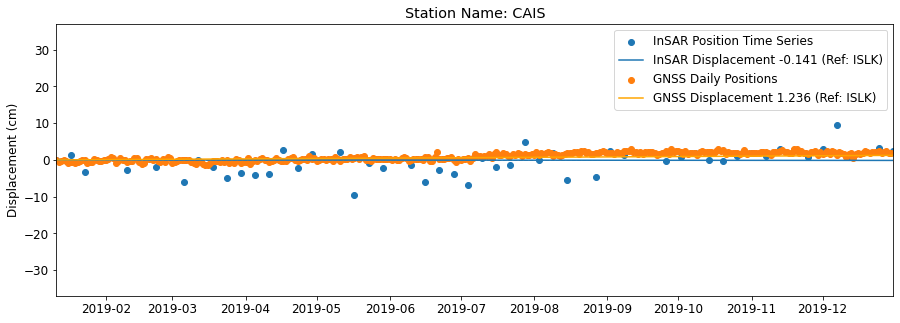

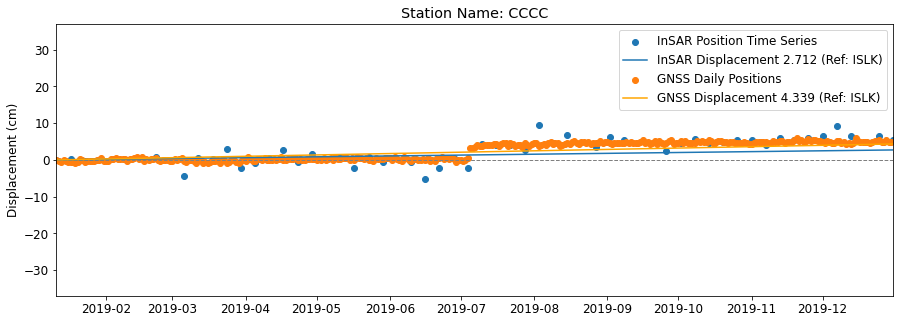

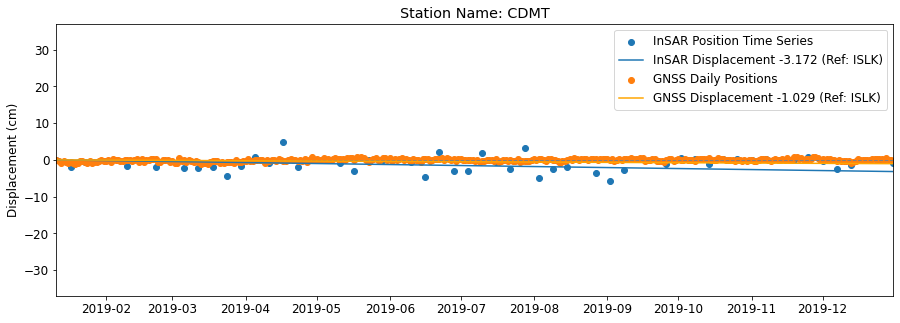

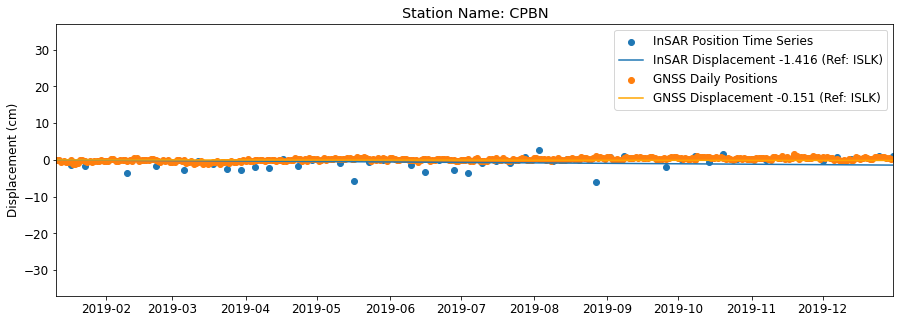

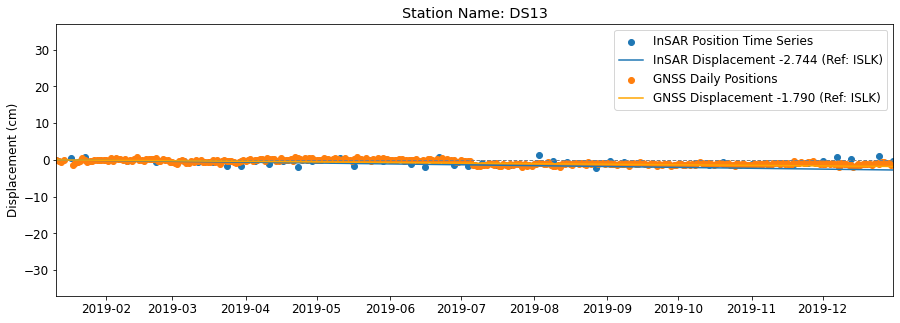

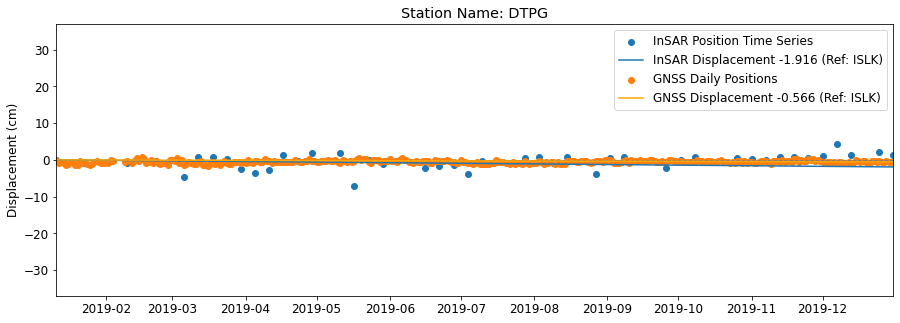

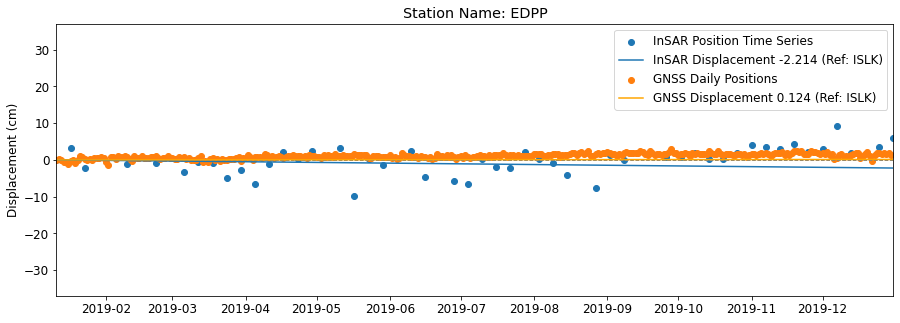

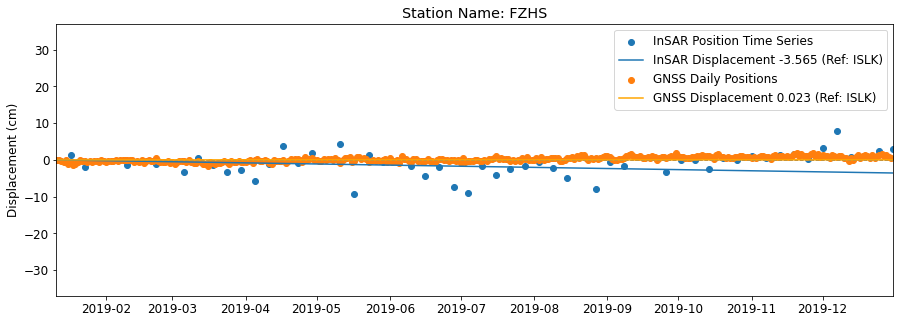

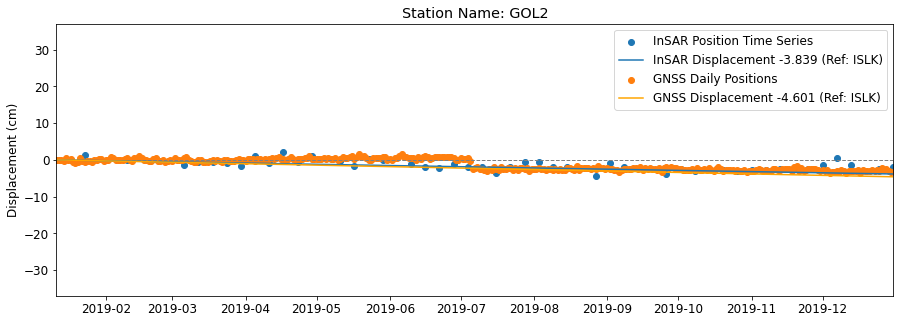

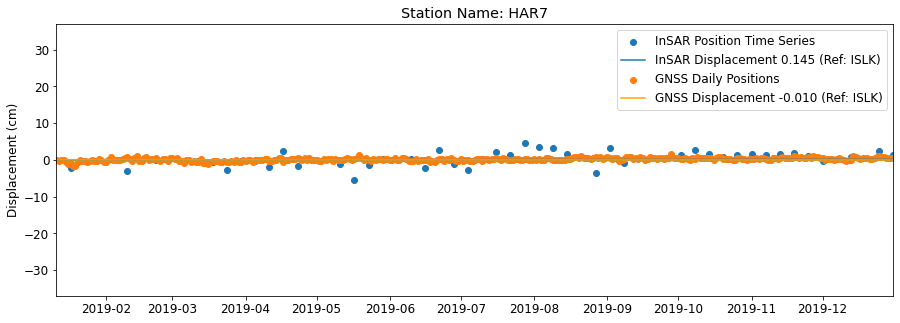

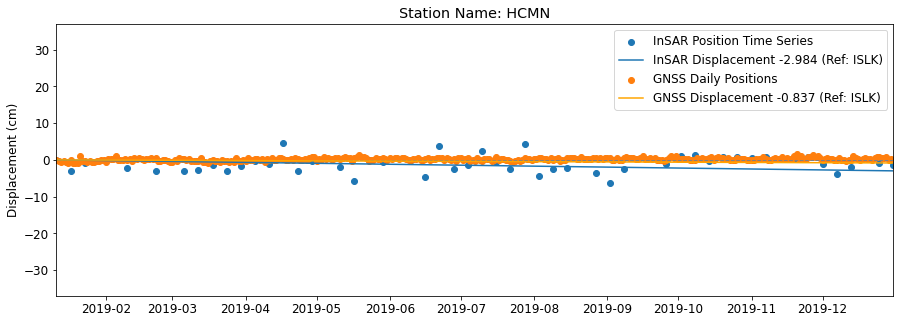

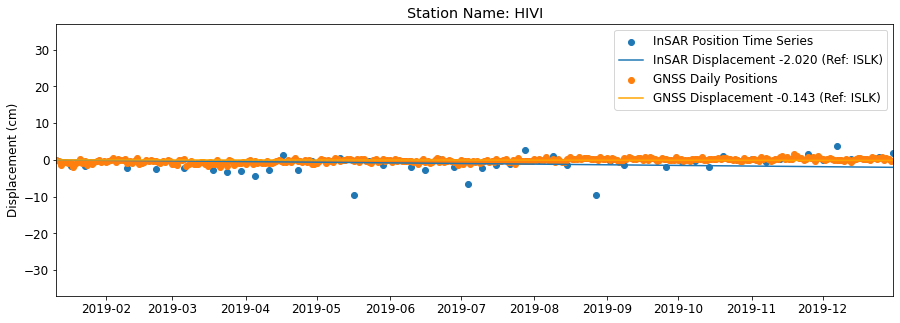

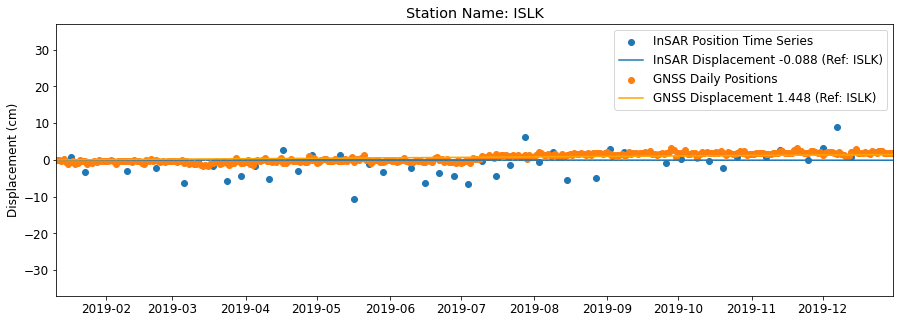

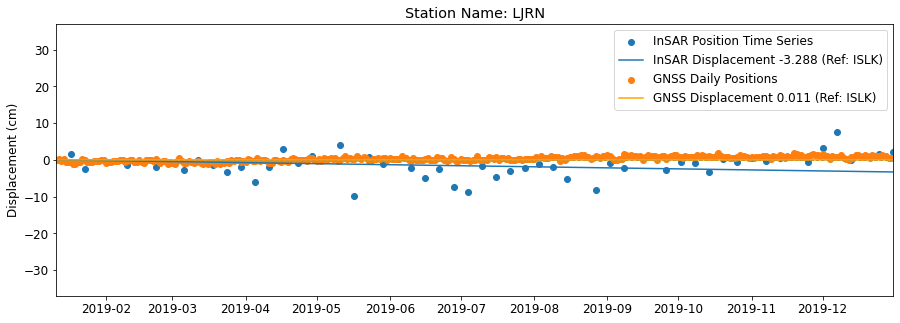

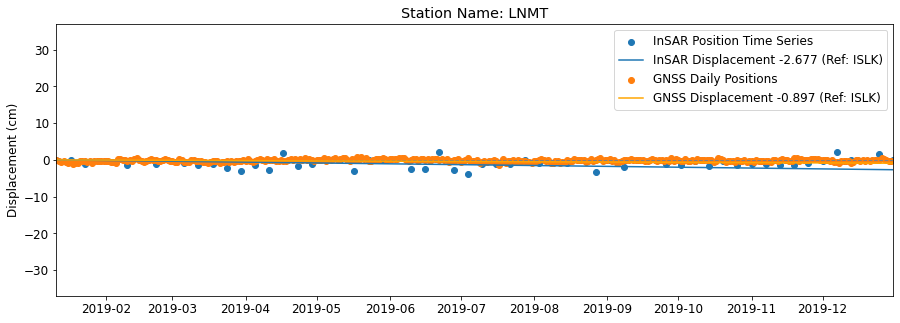

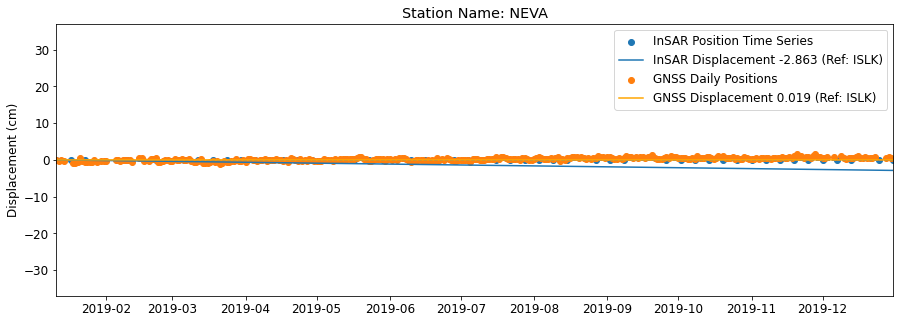

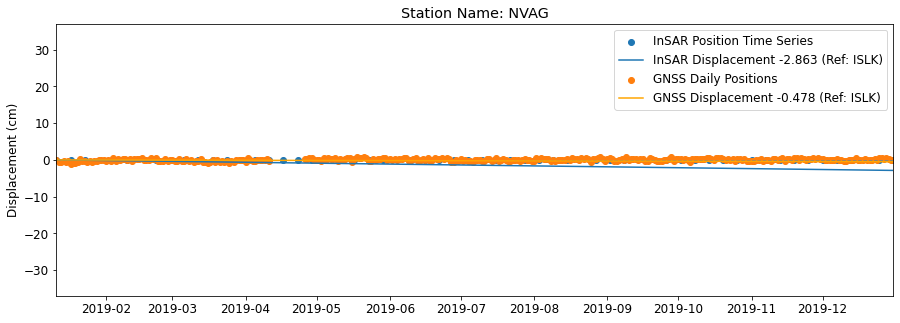

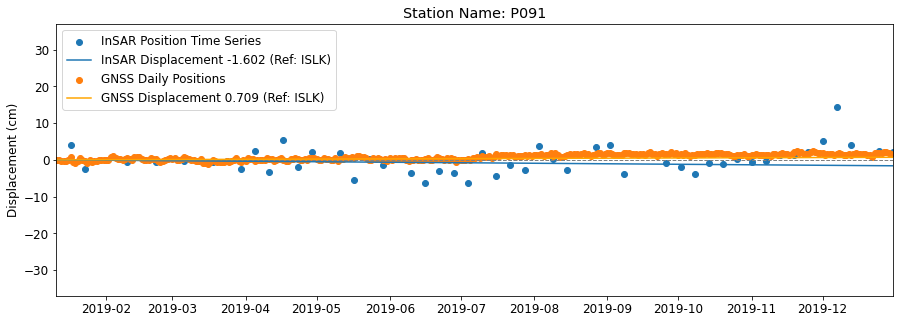

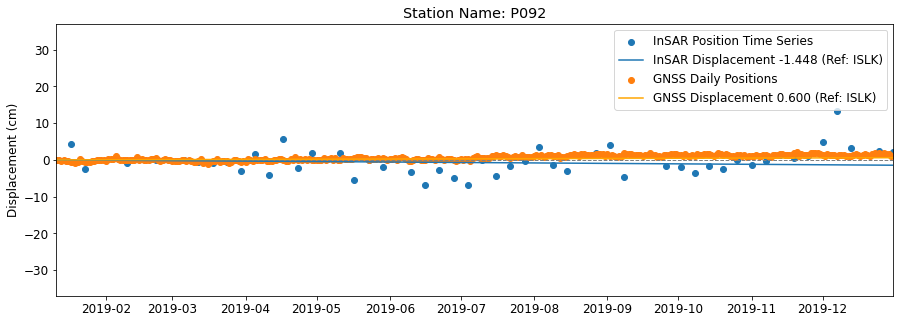

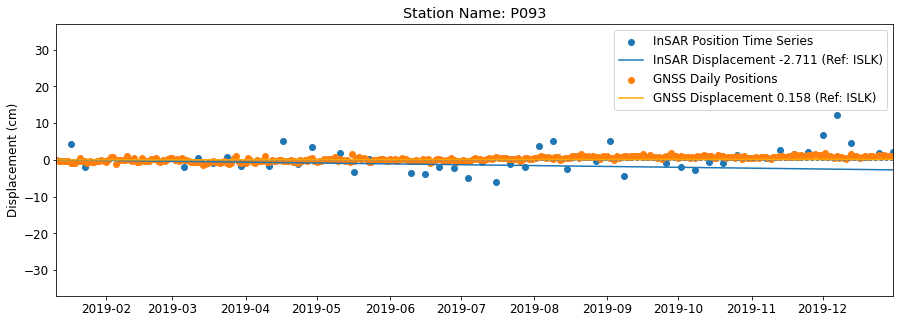

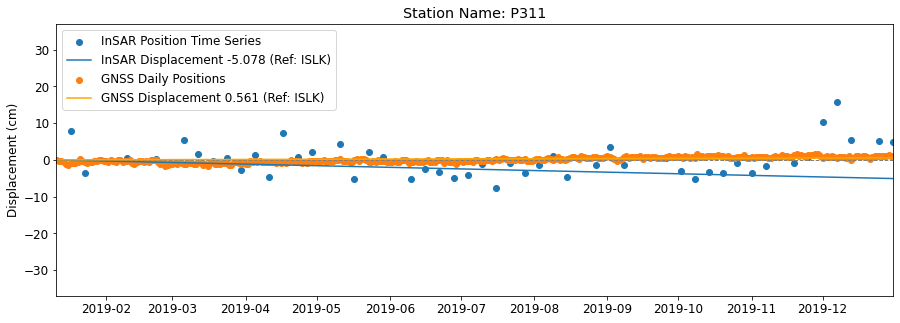

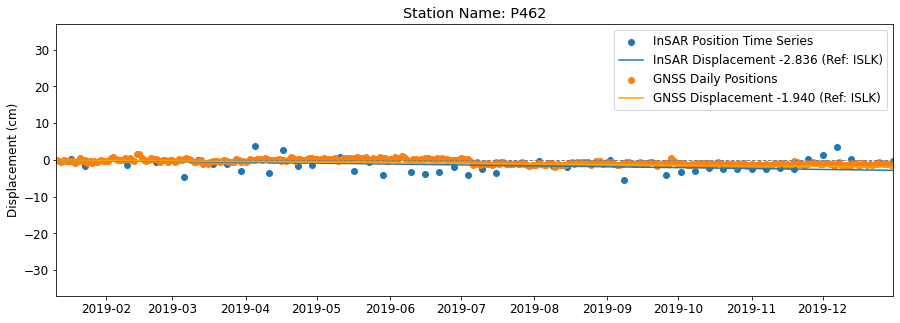

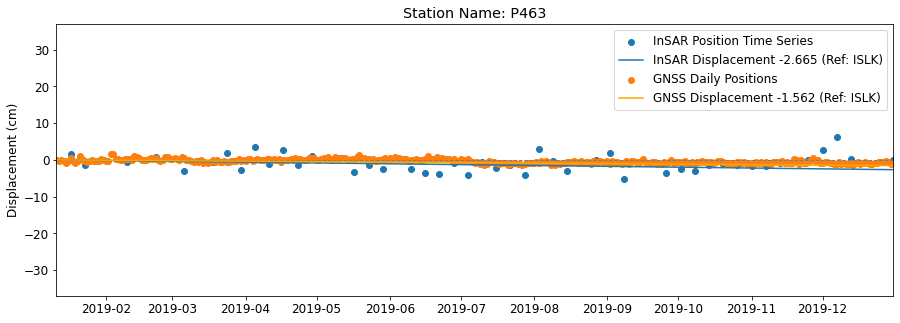

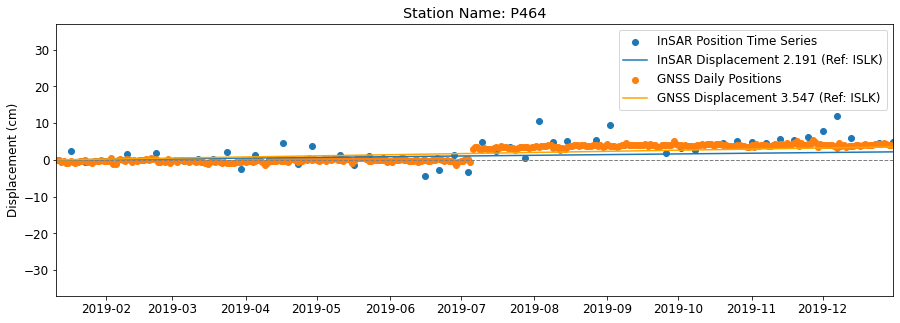

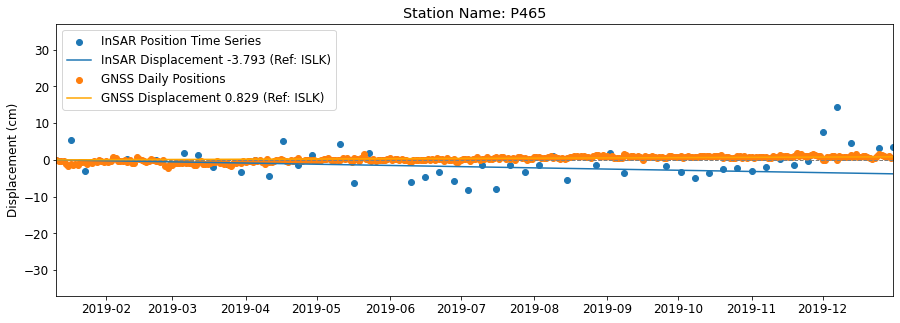

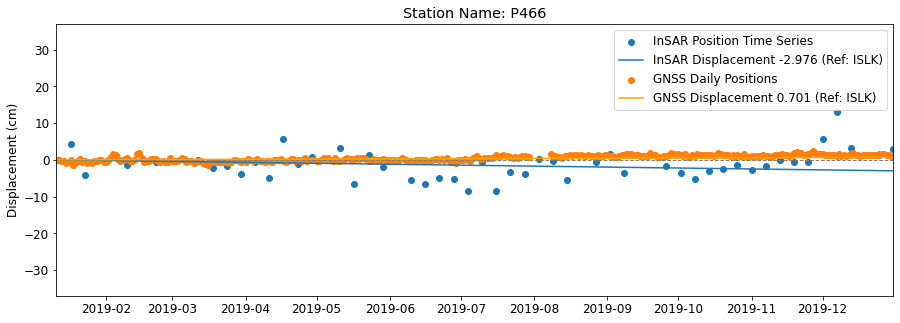

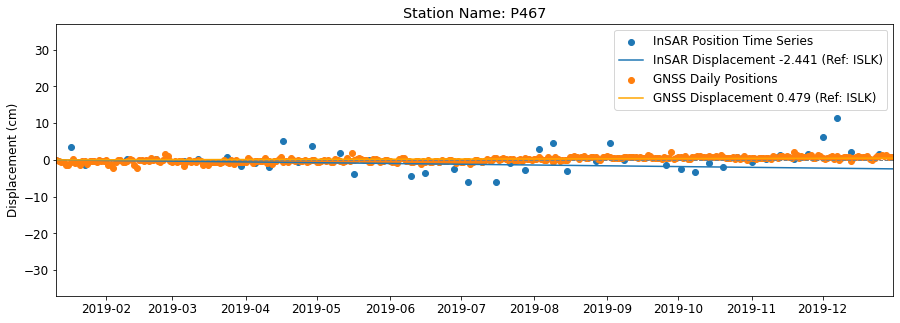

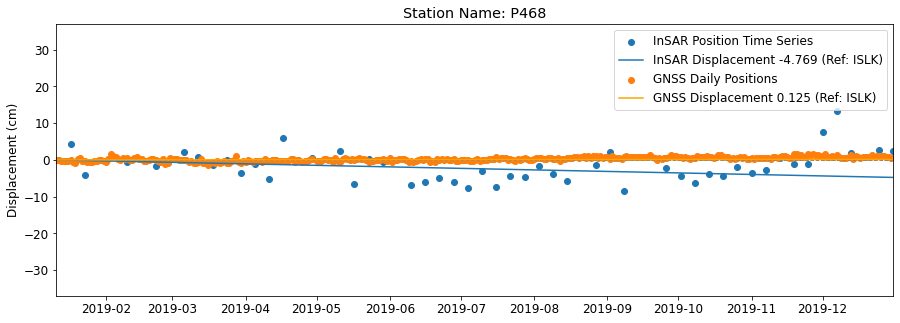

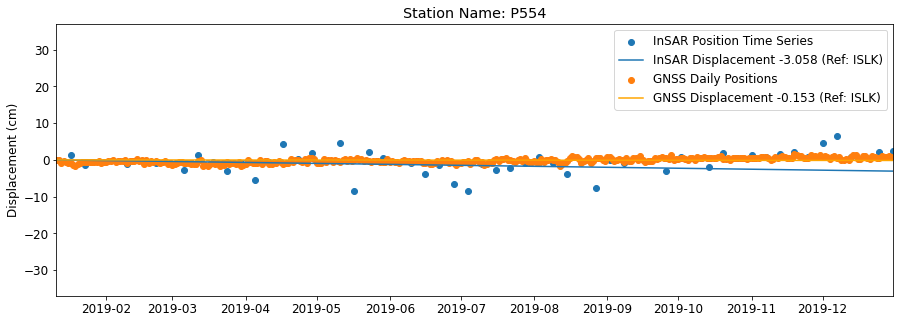

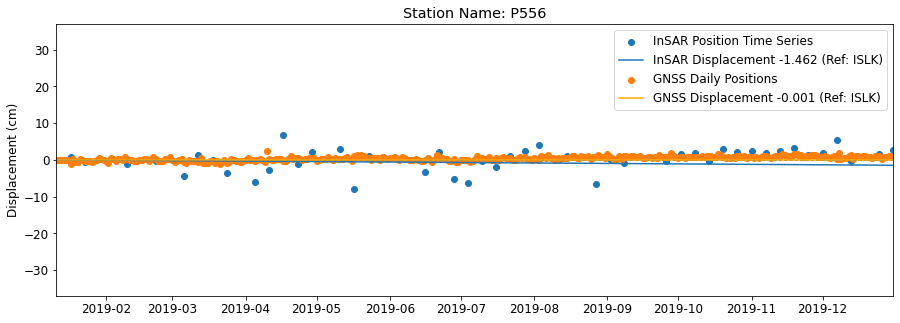

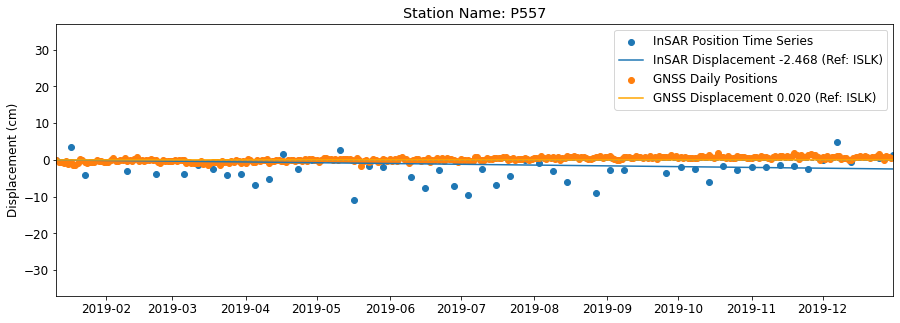

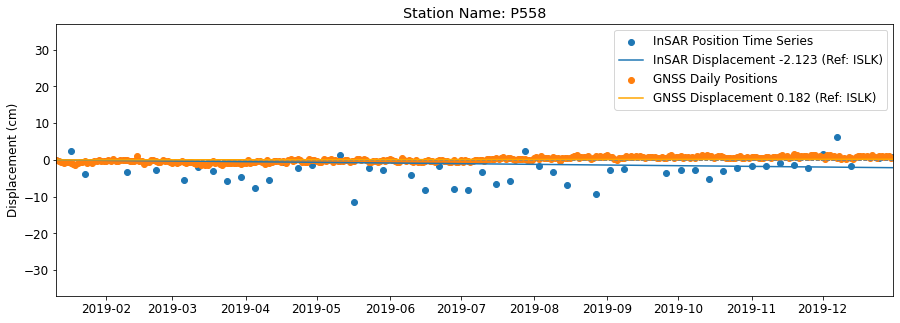

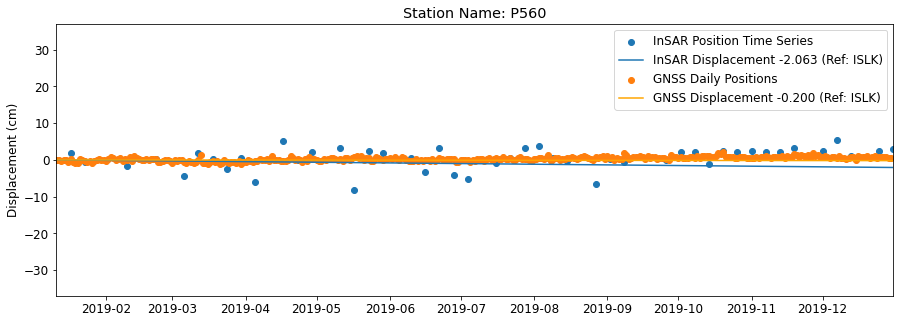

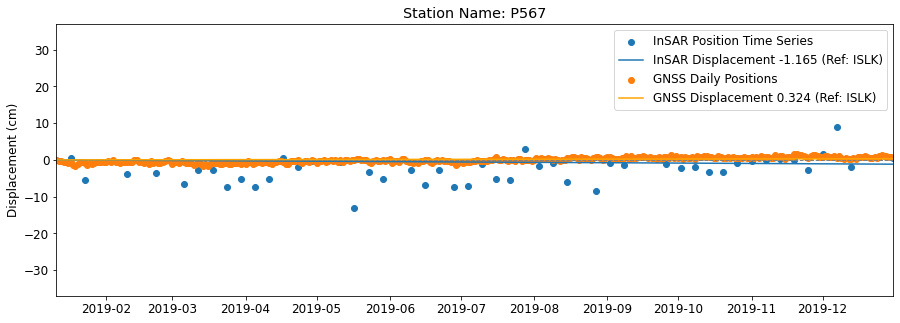

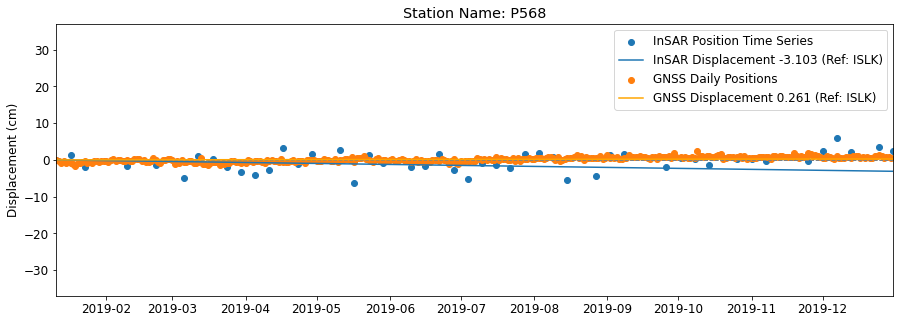

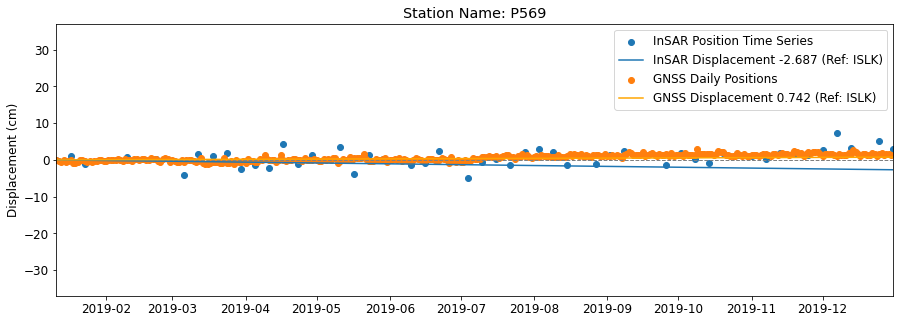

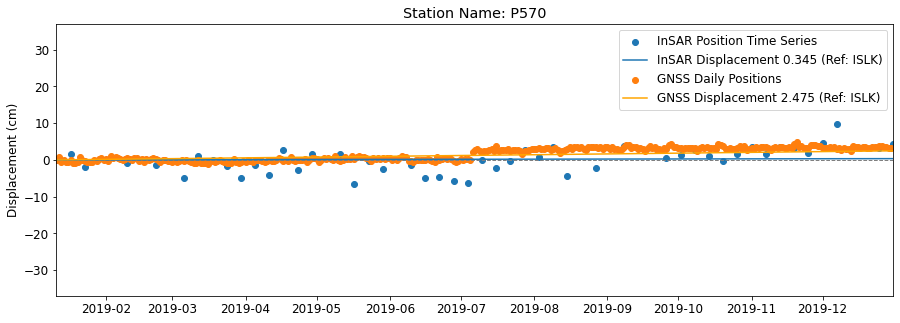

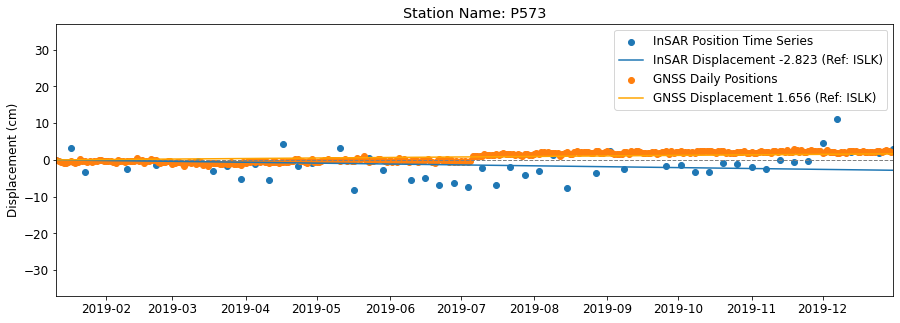

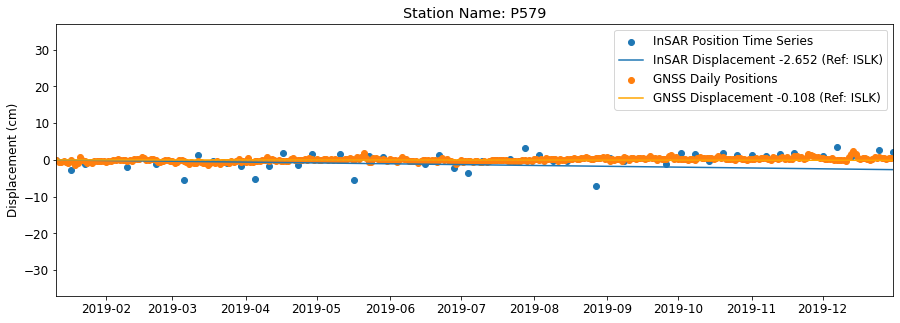

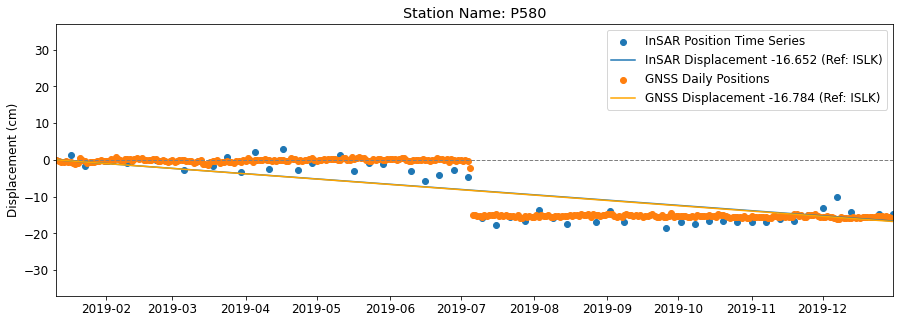

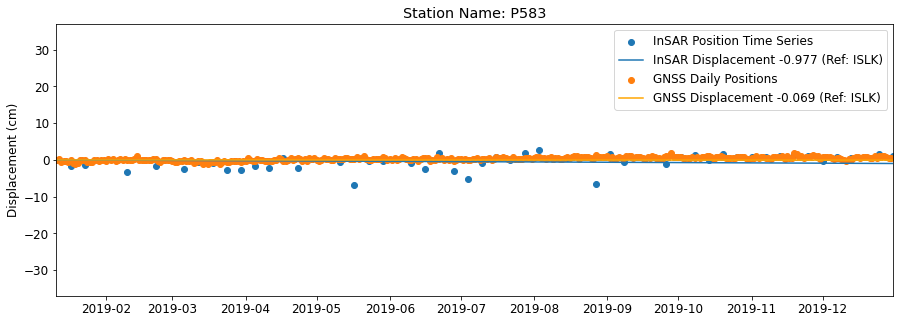

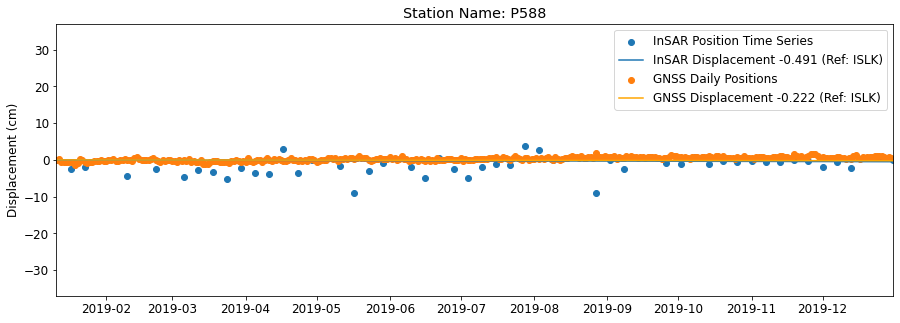

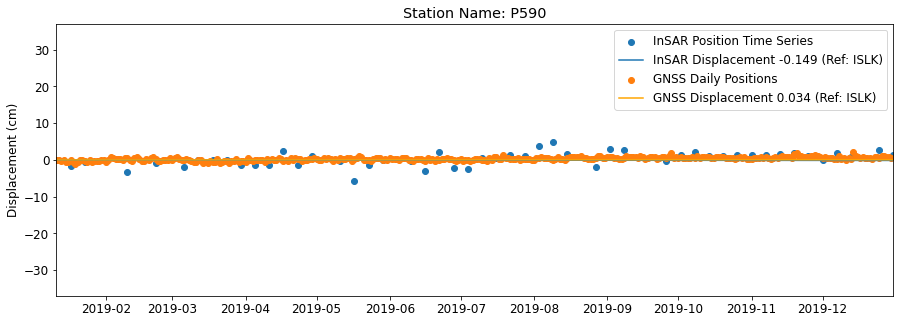

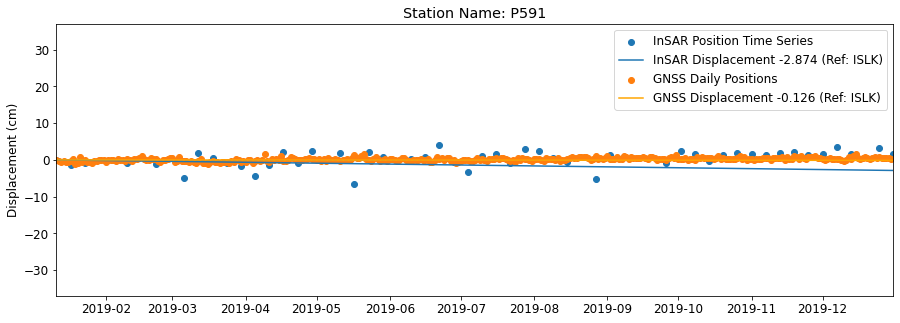

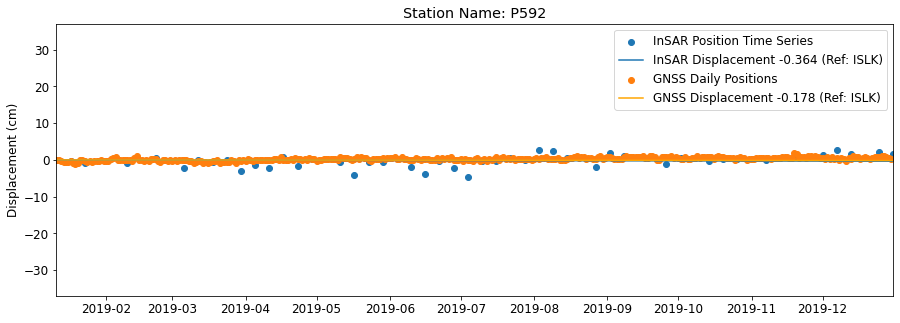

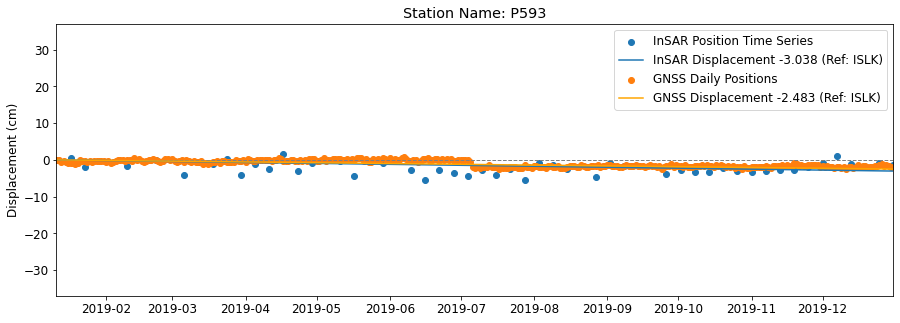

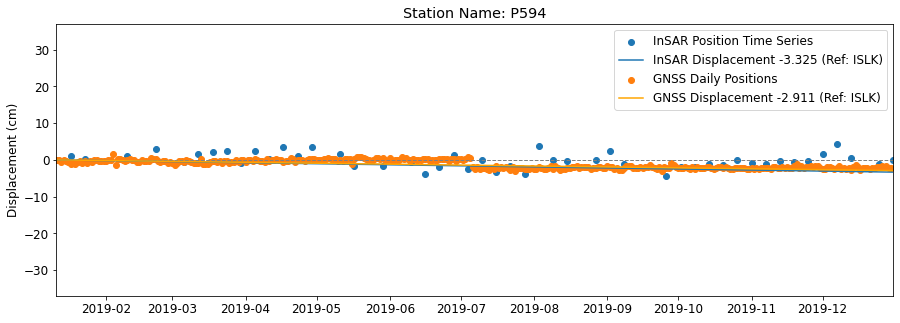

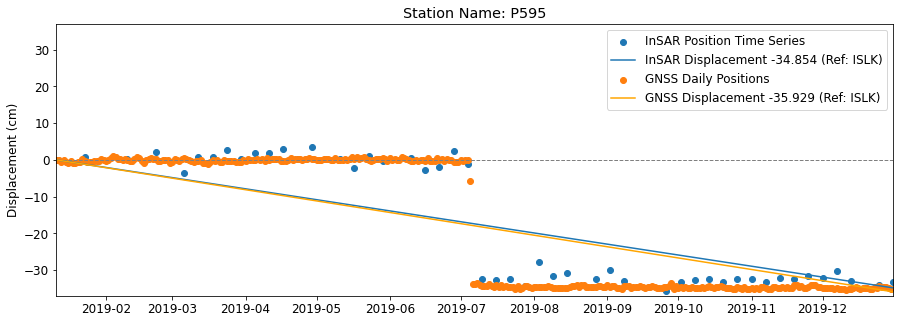

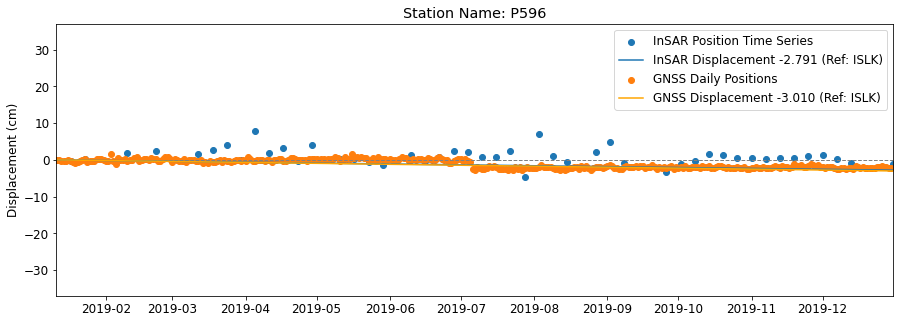

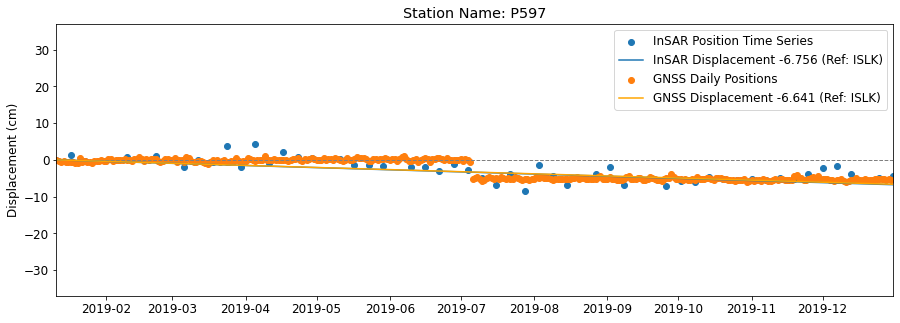

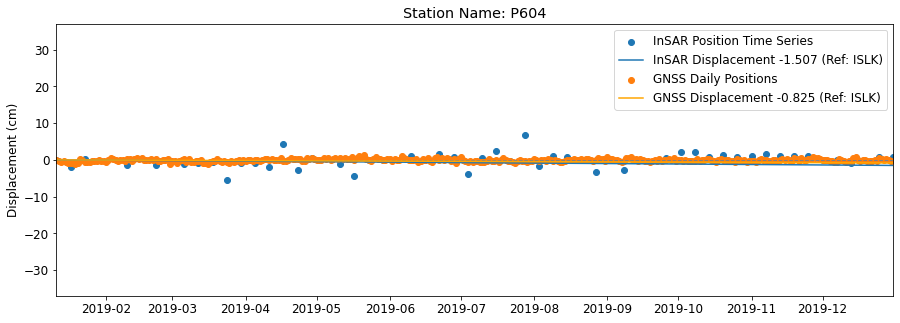

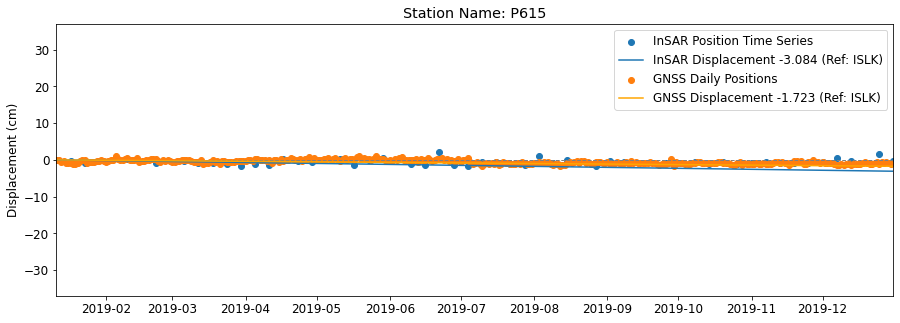

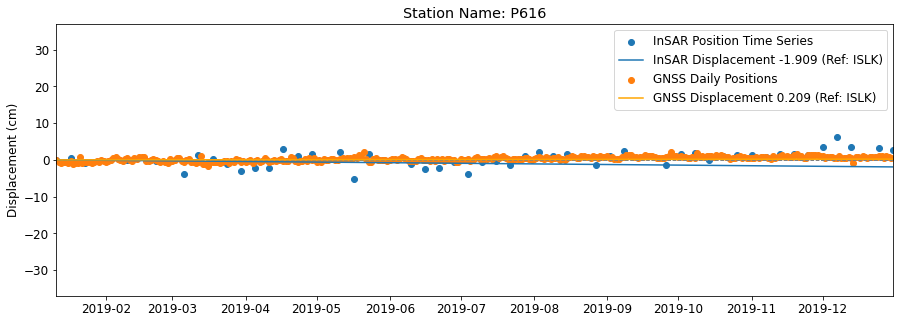

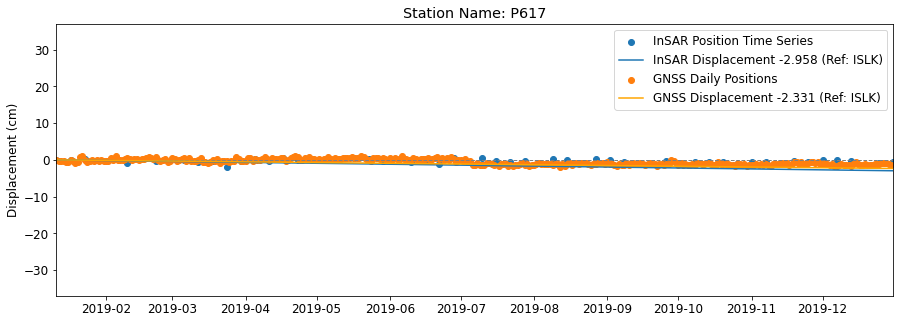

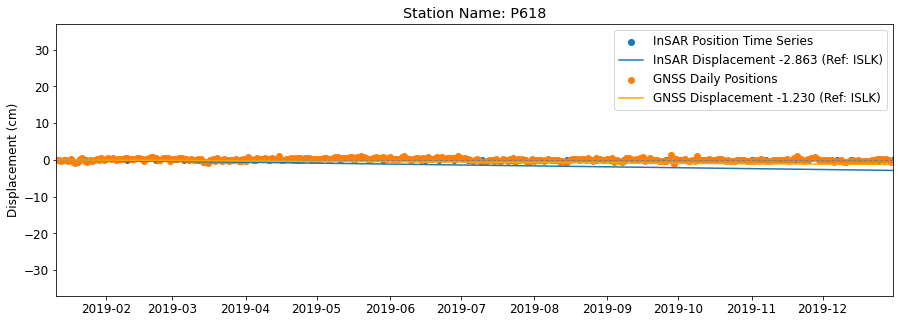

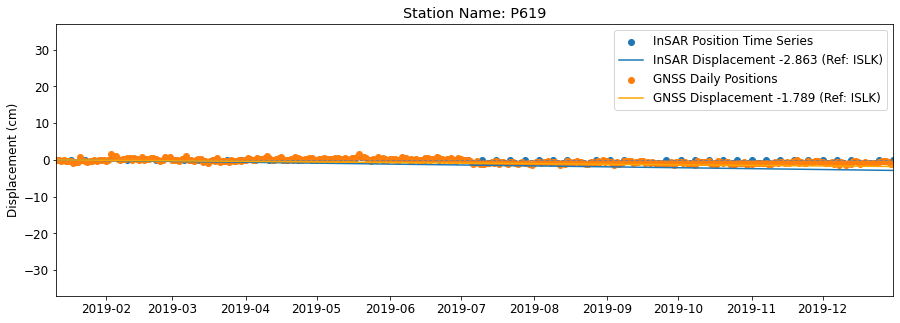

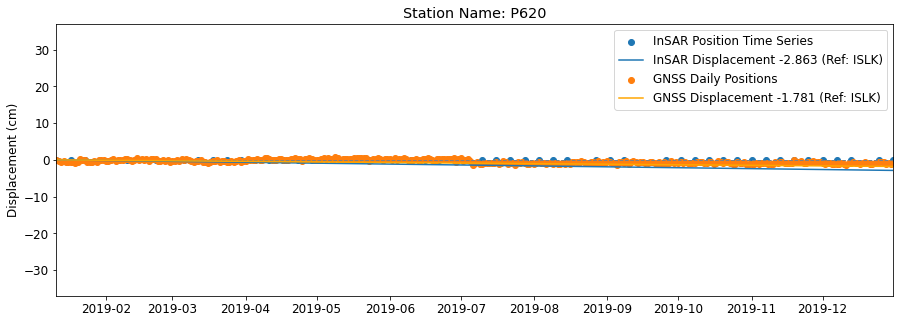

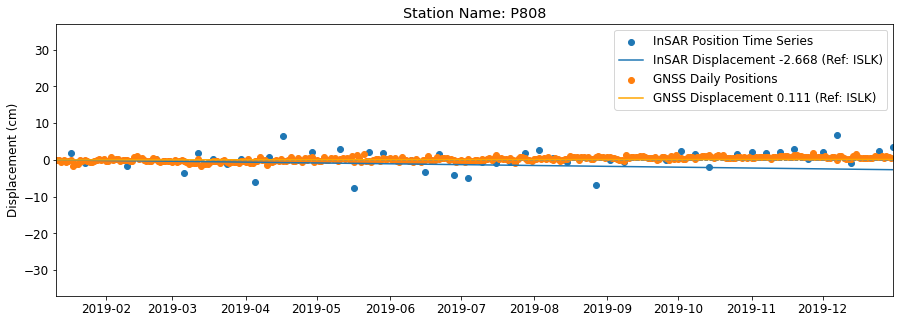

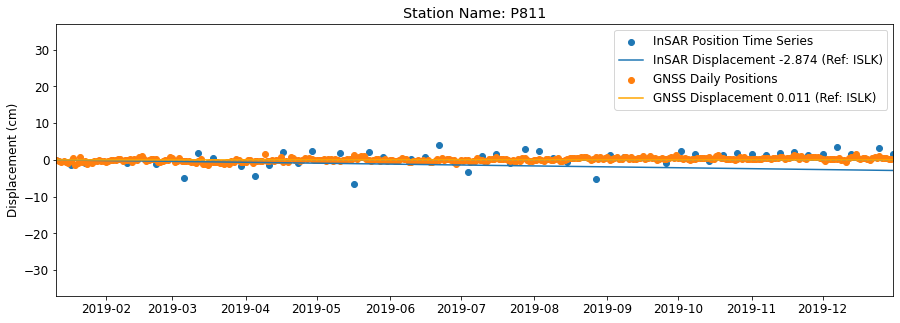

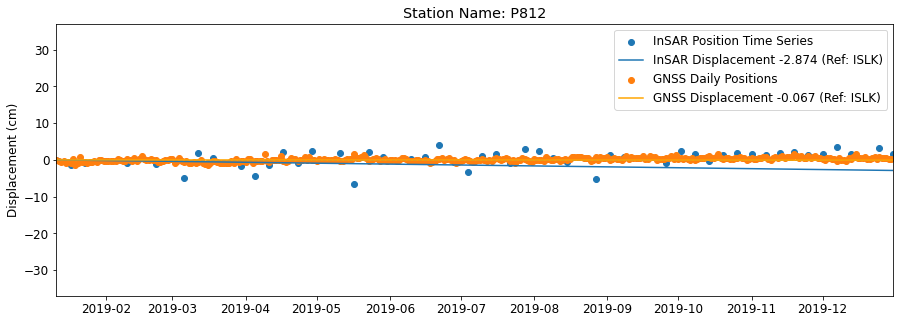

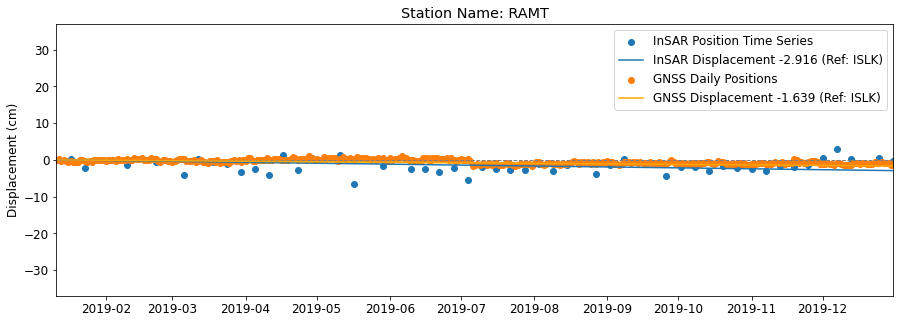

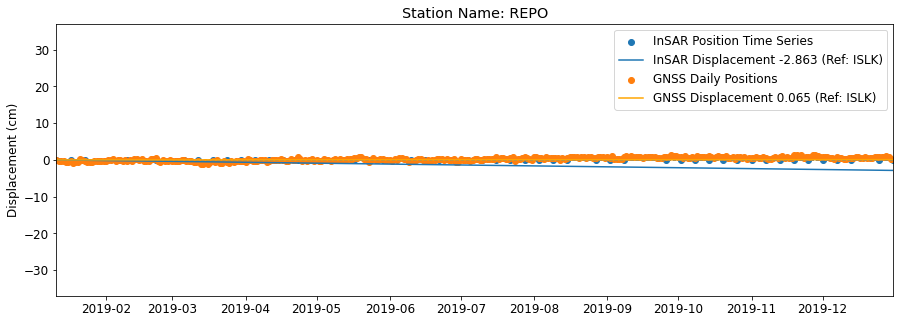

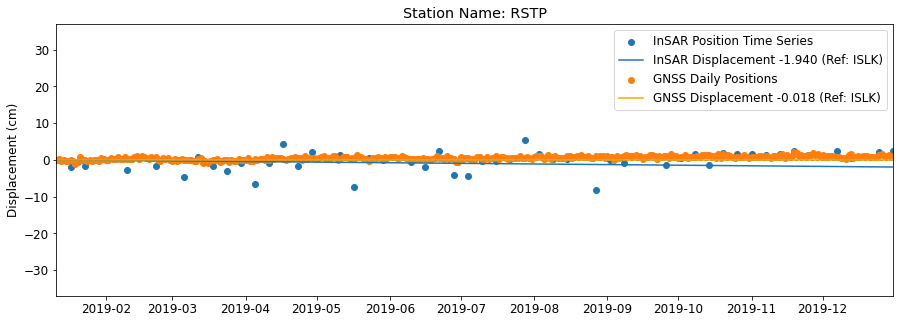

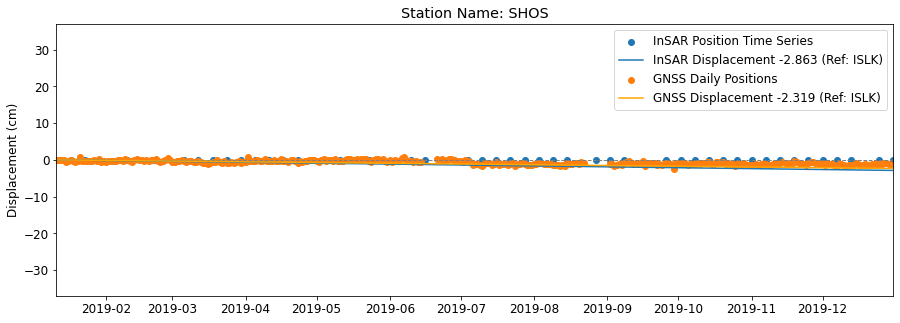

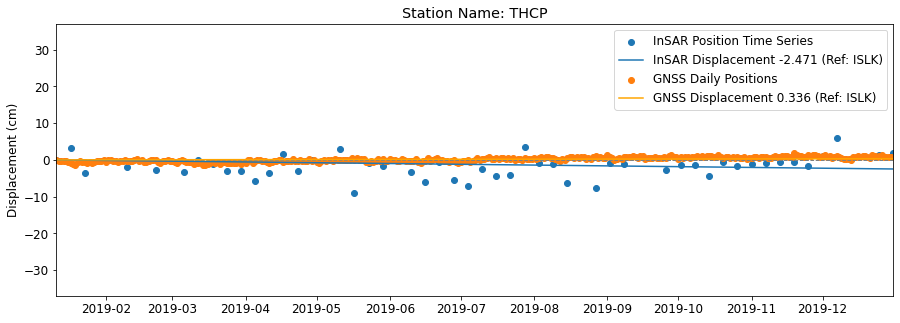

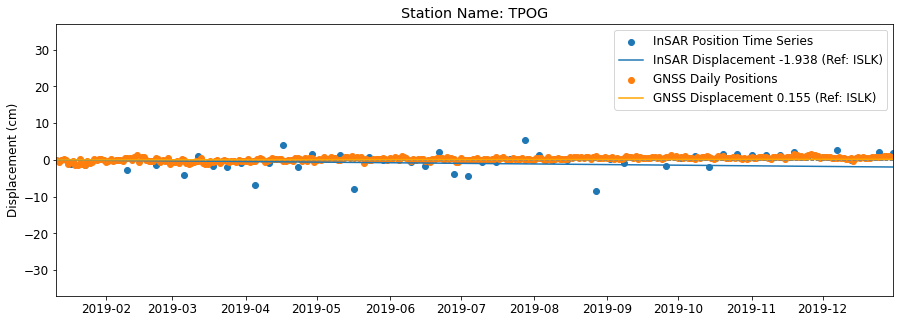

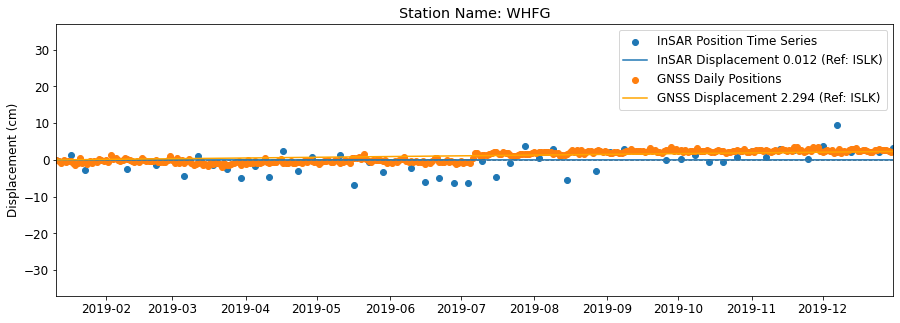

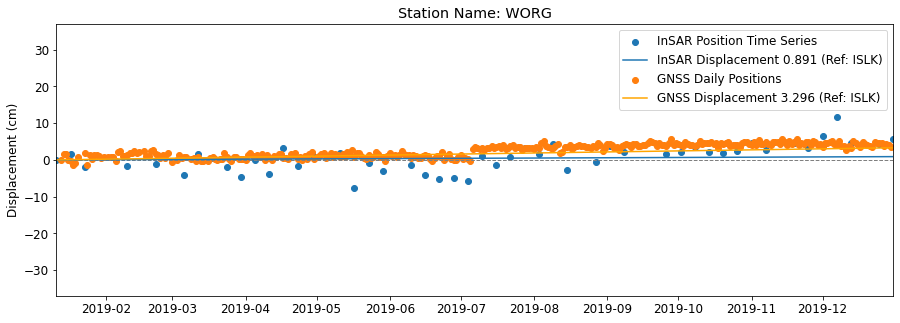

In [94]:
#Read in timeseries file
time_file = os.path.join(work_dir, 'MintPy/timeseries.h5')
insar_displacements = readfile.read(time_file, datasetName='timeseries')[0] * 100.

#Get aquisition dates, trim the str, and convert to datetime
raw_aqu_list = readfile.get_slice_list(time_file)
acquisitions_dates = []
for i in range(len(raw_aqu_list)):
    date = raw_aqu_list[i].split("-")
    #aqu_dates.append = date[1]
    acquisitions_dates.append(dt.strptime(date[1], "%Y%m%d"))
ndates = len(acquisitions_dates)

#Plot displacements and velocity timeseries at GNSS station locations
test_list = site_names
#test_list = ['P595'] #', 'CAHA', 'CAKC', 'CAND', 'CARH'] #for testing, remove after
for stn in test_list:
    
    #InSAR Info
    insar_timeseries = []
    stn_x = (stn_dict[stn][0])
    stn_y = (stn_dict[stn][1])
    for i in range(ndates):
        insar_displacement = insar_displacements[i,stn_y,stn_x]
        insar_timeseries.append(insar_displacement)     
    InSAR_stn_disp = stn_dict[stn][2]
    GNSS_stn_disp = stn_dict[stn][3]
    #print(InSAR_stn_vel)
    #print(GNSS_stn_vel)
    
    #get the length of time between first and last interferogram for velocity plotting
    insar_timespan = acquisitions_dates[ndates - 1] - acquisitions_dates[0]
    conversion = insar_timespan.days/365.25
    aqu_dates_convert=acquisitions_dates #/conversion
    
    #Plot InSAR
    plt.figure(figsize=(15,5))  
    plt.plot([0,100000],[0,0], color='grey',linestyle='dashed',linewidth=1)
    plt.scatter(acquisitions_dates, insar_timeseries, label="InSAR Position Time Series")
    #velocity trendline
    plt.plot([acquisitions_dates[0], acquisitions_dates[ndates - 1]],[0,InSAR_stn_disp],label=f"InSAR Displacement {InSAR_stn_disp:.3f} (Ref: {sites[site]['gps_ref_site_name']})")

    #GNSS Info
    gps_obj = gps.GPS(site = stn, data_dir = mintpy_dir + '/GPS')
    gps_obj.open()
    dates = gps_obj.dates
    # date range for this station
    statStart = gps_obj.date_list[0]
    statEnd = gps_obj.date_list[-1]

    dates, disp_los, std, site_lalo, ref_site_lalo = gps_obj.read_gps_los_displacement(geom_file, start_date=statStart, end_date=statEnd, ref_site=None,
                                  gps_comp=gps_comp, print_msg=False)
    
    #Plot GNSS
    index_begin = np.min(np.where(dates >= start_date_gnss))
    index_end = np.max(np.where(dates <= end_date_gnss))
    dates_cut = dates[index_begin:index_end]
    disp_los_cut = disp_los[index_begin:index_end]
    disp_los_cut = (disp_los_cut - np.median(disp_los_cut))*100
    plt.scatter(dates_cut, disp_los_cut - disp_los_cut[0], label="GNSS Daily Positions")   
    #velocity trendline
    plt.plot([acquisitions_dates[0], acquisitions_dates[ndates - 1]],[0,GNSS_stn_disp],color='orange',label=f"GNSS Displacement {GNSS_stn_disp:.3f} (Ref: {sites[site]['gps_ref_site_name']})")

    plt.title(f"Station Name: {stn}") 
    plt.ylabel('Displacement (cm)')
    plt.ylim(-37,37) # plot range for Ridgecrest
    plt.xlim(aqu_dates_convert[0],aqu_dates_convert[ndates - 1])
    plt.legend(loc="best")
    

<a id='calval_sites'></a>
## 7.5. List of CalVal Sites:


In [51]:
#####################################################################################################################
#####################################################################################################################
'''
Set NISAR calval sites:
    CentralValleyA144  : Central Valley
    OklahomaA107       : Oklahoma
    PuertoRicoD98      : Puerto Rico (Earthquake M6.4 on 20200107) - Descending track 
    PuertoRicoA135     : Puerto Rico (Earthquake M6.4 on 20200107 & large aftershock on 20200703) - Ascending track
    RidgecrestD71      : Ridgecrest  (Earthquake M7.2 on 20190705) - Descending track
    RidgecrestA64      : Ridgecrest  (Earthquake M7.2 on 20190705) - Ascending track

ARIA parameters:
    calval_location : name
    download_region : download box in S,N,W,E format
    analysis_region : analysis box in S,N,W,E format (must be within download_region)
    download_start_date : download start date as YYYMMDD  
    download_end_date   : download end date as YYYMMDD
    earthquakeDate :  arbitrary date for testing with the central_valley dataset
    sentinel_track : sentinel track to download
    gps_ref_site_name : Name of the GPS site for InSAR re-referencing
    tempBaseMax' : maximum number of days, 'don't use interferograms longer than this value 
    ifgExcludeList : default is not to exclude any interferograms
    maskWater' :  interior locations don't need to mask water
'''
#####################################################################################################################
#####################################################################################################################

sites = {
    ##########  CENTRAL VALLEY ##############
    'CentralValleyA144' : {'calval_location' : 'Central_Valley',
            'download_region' : '"36.18 36.26 -119.91 -119.77"', # download box in S,N,W,E format
            'analysis_region' : '"35.77 36.75 -120.61 -118.06"', # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20180101',
            'download_end_date' : '20180801',
            'earthquakeDate' : '20180412',                       # arbitrary date for testing with the central_valley dataset
            'sentinel_track' : '144',
            'gps_ref_site_name' : 'P467',
            'tempBaseMax' : 'auto',
            'ifgExcludeList' : 'auto',
            'maskWater' : False},                       # reference site for this area
    ##########  OKLAHOMA ##############
    'OklahomaA107' : {'calval_location' : 'Oklahoma',
            'download_region' : '"31.7 37.4 -103.3 -93.5"',      # download box in S,N,W,E format
            'analysis_region' : '"35.25 36.5 -100.5 -98.5"',     # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20210101',
            'download_end_date' : '20210801',
            'earthquakeDate' : '20210328',                       # arbitrary date for testing with the Oklahoma dataset
            'sentinel_track' : '107',
            'gps_ref_site_name' : 'OKCL',
            'tempBaseMax' : 'auto',
            'ifgExcludeList' : 'auto',
            'maskWater' : False},
    ##########  PUERTO RICO ##############
    'PuertoRicoD98' : {'calval_location' : 'PuertoRicoDesc',
            'download_region' : '"17.5 18.9 -67.5 -66.0"',       # download box in S,N,W,E format
            'analysis_region' : '"17.9 18.5 -67.3 -66.2"',       # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20190701',
            'download_end_date' : '20200930',
            'earthquakeDate' : '20200107',                       # date of M6.4 quake
            'sentinel_track' : '98',                             # descending track
            'gps_ref_site_name' : 'PRLT',
            'tempBaseMax' : 24,                                  # don't use interferograms longer than 24 days
            'ifgExcludeList' : 'auto', 
            'maskWater' : True},                                 # need to mask ocean around Puerto Rico island
    'PuertoRicoA135' : {'calval_location' : 'PuertoRicoAsc',
             'download_region' : '"17.5 18.9 -67.5 -66.0"',      # download box in S,N,W,E format
             'analysis_region' : '"17.9 18.5 -67.3 -66.2"',      # analysis box in S,N,W,E format (must be within download_region)
             'download_start_date' : '20190701',
             'download_end_date' : '20200930',
             'earthquakeDate' : '20200107',                      # date of M6.4 quake
             'earthquakeDate2' : '20200703',                     # date of large aftershock
             'sentinel_track' : '135',                           # ascending track
             'gps_ref_site_name' : 'PRLT',
             'tempBaseMax' : 24,                                 # don't use interferograms longer than 24 days
             'ifgExcludeList' : 'auto',
             'maskWater' : True},                                # need to mask ocean around Puerto Rico island
    ##########  RIDGECREST ##############
    'RidgecrestD71': {'calval_location' : 'RidgecrestD71',
                      'download_region' : '"34.5 37.5 -119.0 -116.0"', # download box in S,N,W,E format
                      'analysis_region' : '"34.7 37.2 -118.9 -116.1"', # analysis box in S,N,W,E format (must be within download_region)
                      'download_start_date' : '20190601',
                      'download_end_date' : '20190831',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '71',
                      'gps_ref_site_name' : 'ISLK',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : 'auto',
                      'maskWater' : False},
    'RidgecrestA64': {'calval_location' : 'Ridgecrest',
                      'download_region' : '"34.5 37.5 -119.0 -116.0"', # download box in S,N,W,E format
                      'analysis_region' : '"34.7 37.2 -118.9 -116.1"', # analysis box in S,N,W,E format (must be within download_region)
                      'download_start_date' : '20190101',
                      'download_end_date' : '20191231',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '64',
                      'gps_ref_site_name' : 'ISLK',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : '[50,121,123,124,125,126]',   # list of bad ifgs to exclude from time-series analysis
                      'maskWater' : False}
}
%store sites
os.system(f'cp  ~/.ipython/profile_default/db/autorestore/sites {work_dir}/../../../../.')

Stored 'sites' (dict)
